In [1]:
import os
import pickle
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import warnings

warnings.filterwarnings('ignore')
 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
with open("data/simulation_results_2025_08_04_17_54_30.pkl", "rb") as file:
    data = pickle.load(file)
    days = data["SIMULATION_DAYS_ARRAY_KEY"]
    print(days[60].keys())


dict_keys(['DAY_KEY', 'CUSTOMER_ORDERS_KEY', 'SUPPLIER_ORDERS_KEY', 'NEEDED_INGREDIENTS_KEY', 'CLOSEST_ORDER_KEY', 'TOTAL_INCOME', 'ORDER_FULFILLED_LIST'])


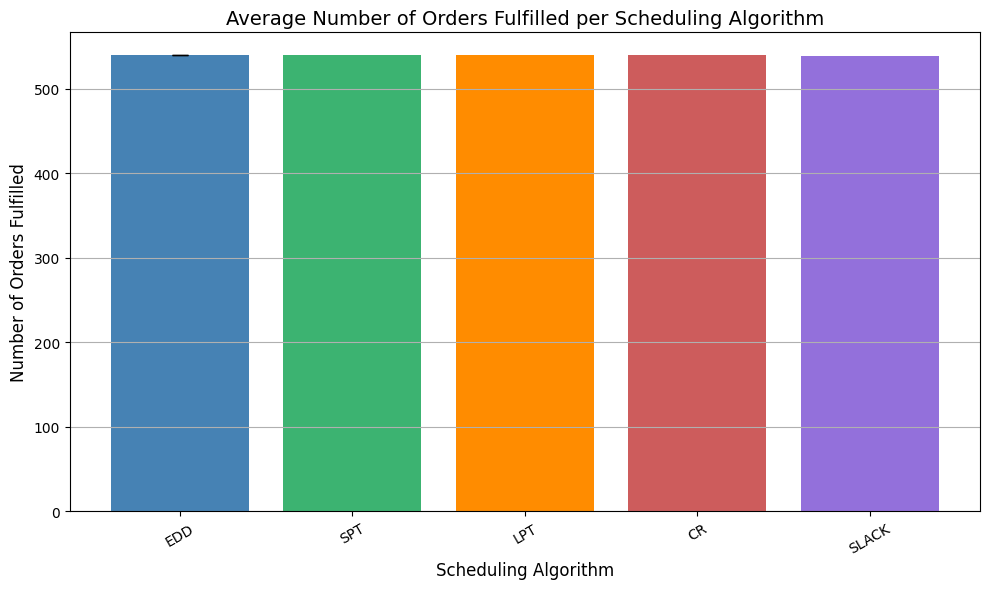

In [3]:
color_map = {
    "EDD": "steelblue",
    "SPT": "mediumseagreen",
    "LPT": "darkorange",
    "CR": "indianred",
    "SLACK": "mediumpurple",
    "UNKNOWN": "gray"
}

short_names = {
    "ALGORITHM_EDD": "EDD",
    "ALGORITHM_SPT": "SPT",
    "ALGORITHM_LPT": "LPT",
    "ALGORITHM_CRITICAL_RATIONAL": "CR",
    "ALGORITHM_SLACK": "SLACK"
}

folder_path = "data/"
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".pkl")]

results = defaultdict(list)

for path in file_paths:
    try:
        with open(path, "rb") as file:
            data = pickle.load(file)
            days = data.get("SIMULATION_DAYS_ARRAY_KEY", [])
            warmup_days = 60  # תקופת חימום

            total_orders = sum(len(day.get("ORDER_FULFILLED_LIST", [])) for day in days[warmup_days:])
            algo_full = data.get("ALGORITHM_KEY", "UNKNOWN")
            algo = short_names.get(algo_full, algo_full.replace("ALGORITHM_", ""))
            results[algo].append(total_orders)
    except Exception as e:
        print(f"Problem with file {path}: {e}")

summary = pd.DataFrame([
    {
        "Algorithm": alg,
        "Mean Orders Fulfilled": pd.Series(vals).mean(),
        "Std Dev": pd.Series(vals).std(),
        "Runs": len(vals)
    }
    for alg, vals in results.items()
])

summary = summary.sort_values(by="Mean Orders Fulfilled", ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(
    summary["Algorithm"],
    summary["Mean Orders Fulfilled"],
    yerr=summary["Std Dev"],
    capsize=6,
    color=[color_map.get(alg, "gray") for alg in summary["Algorithm"]]
)
plt.title("Average Number of Orders Fulfilled per Scheduling Algorithm", fontsize=14)
plt.xlabel("Scheduling Algorithm", fontsize=12)
plt.ylabel("Number of Orders Fulfilled", fontsize=12)
plt.xticks(rotation=30)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# summary.to_csv("scheduling_algorithm_order_fulfillment.csv", index=False)


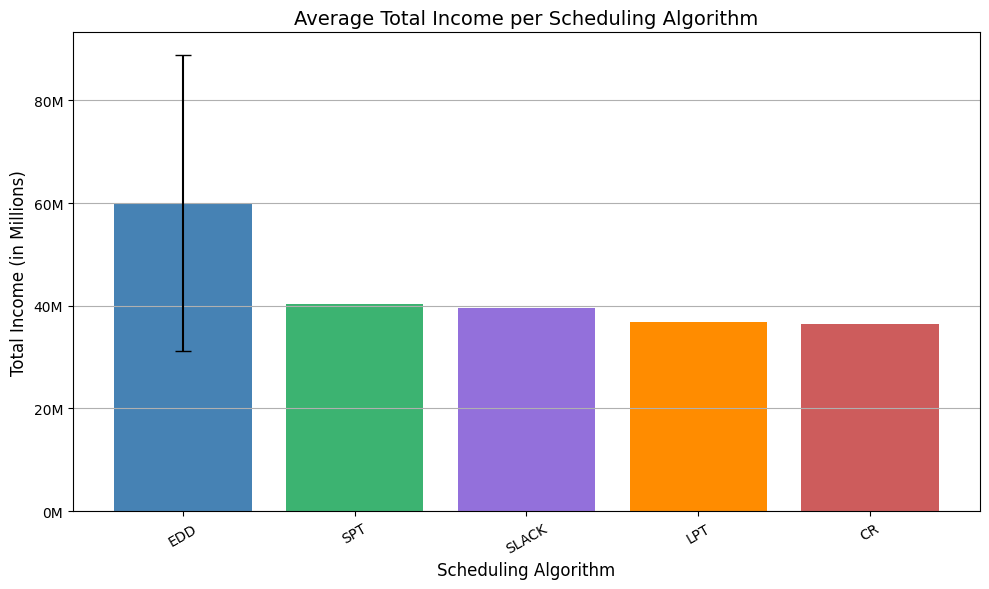

In [4]:
# Define colors manually per algorithm
color_map = {
    "EDD": "steelblue",
    "SPT": "mediumseagreen",
    "LPT": "darkorange",
    "CR": "indianred",
    "SLACK": "mediumpurple",
    "UNKNOWN": "gray"
}

# Optional: mapping from full keys to short names
short_names = {
    "ALGORITHM_EDD": "EDD",
    "ALGORITHM_SPT": "SPT",
    "ALGORITHM_LPT": "LPT",
    "ALGORITHM_CRITICAL_RATIONAL": "CR",
    "ALGORITHM_SLACK": "SLACK"
}


results = defaultdict(list)

for path in file_paths:
    try:
        with open(path, "rb") as file:
            data = pickle.load(file)
            days = data["SIMULATION_DAYS_ARRAY_KEY"]
            warmup_days = 60
            total_income = sum(day.get("TOTAL_INCOME", 0) for day in days[warmup_days:])
            full_algo = data.get("ALGORITHM_KEY", "UNKNOWN")
            algo = short_names.get(full_algo, full_algo.replace("ALGORITHM_", ""))  # short fallback
            results[algo].append(total_income)
    except Exception as e:
        print(f"Problem with file {path}: {e}")

# Build summary table
summary = pd.DataFrame([
    {"Algorithm": alg, "Mean Income": pd.Series(val).mean(), "Std Dev": pd.Series(val).std(), "Runs": len(val)}
    for alg, val in results.items()
])

# Sort by income
summary = summary.sort_values(by="Mean Income", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(
    summary["Algorithm"],
    summary["Mean Income"],
    yerr=summary["Std Dev"],
    capsize=6,
    color=[color_map.get(alg, "gray") for alg in summary["Algorithm"]]
)
plt.title("Average Total Income per Scheduling Algorithm", fontsize=14)
plt.xlabel("Scheduling Algorithm", fontsize=12)
plt.ylabel("Total Income (in Millions)", fontsize=12)
plt.xticks(rotation=30)
plt.grid(axis="y")
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x*1e-6:.0f}M'))
plt.tight_layout()
plt.show()

# Save results
summary.to_csv("scheduling_algorithm_summary.csv", index=False)


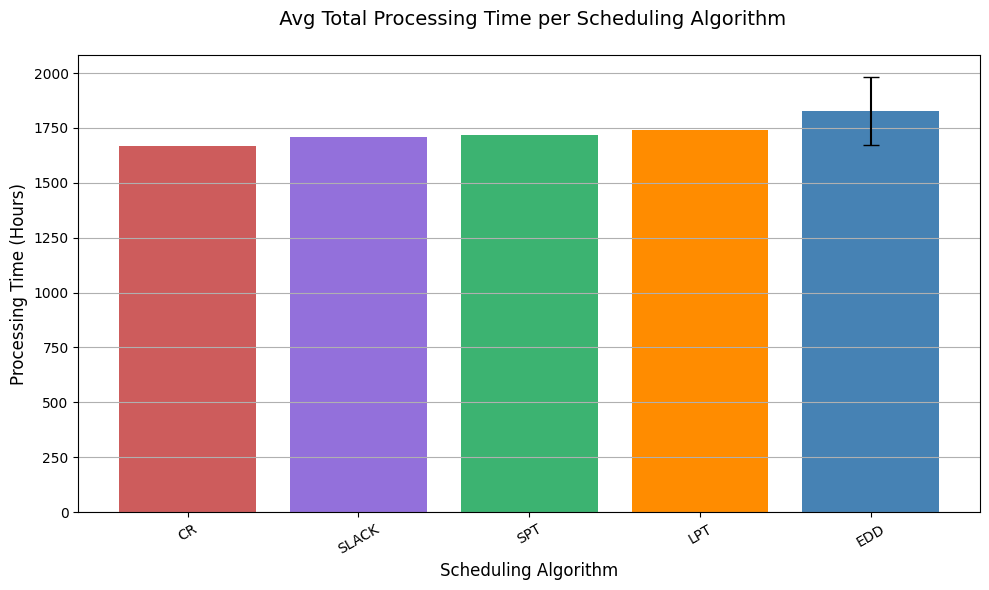

In [5]:
# Color map for each scheduling algorithm
color_map = {
    "EDD": "steelblue",
    "SPT": "mediumseagreen",
    "LPT": "darkorange",
    "CR": "indianred",
    "SLACK": "mediumpurple",
    "UNKNOWN": "gray"
}

# Mapping full algorithm names to short labels
short_names = {
    "ALGORITHM_EDD": "EDD",
    "ALGORITHM_SPT": "SPT",
    "ALGORITHM_LPT": "LPT",
    "ALGORITHM_CRITICAL_RATIONAL": "CR",
    "ALGORITHM_SLACK": "SLACK"
}

# Directory containing simulation .pkl files
warmup_days = 60
results = defaultdict(list)

for path in file_paths:
    try:
        with open(path, "rb") as file:
            data = pickle.load(file)

            processing_time_dict = data.get("PROCESSING_TIME_PER_ORDER")
            if processing_time_dict:
            # Sum processing time only for valid days
                filtered_days = {int(day): orders for day, orders in processing_time_dict.items() if int(day) >= warmup_days}
                total_processing_time = sum(
                    sum(day_times.values()) for day_times in filtered_days.values()
                )
            else:
                total_processing_time = 0

            # Identify algorithm name
            full_algo = data.get("ALGORITHM_KEY", "UNKNOWN")
            algo = short_names.get(full_algo, full_algo.replace("ALGORITHM_", ""))
            results[algo].append(total_processing_time)

    except Exception as e:
        print(f"Error processing file {path}: {e}")

# Create a summary DataFrame
summary = pd.DataFrame([
    {
        "Algorithm": alg,
        "Mean Time": pd.Series(val).mean(),
        "Std Dev": pd.Series(val).std(),
        "Runs": len(val)
    }
    for alg, val in results.items()
])
summary = summary.sort_values(by="Mean Time")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(
    summary["Algorithm"],
    summary["Mean Time"],
    yerr=summary["Std Dev"],
    capsize=6,
    color=[color_map.get(alg, "gray") for alg in summary["Algorithm"]]
)
plt.title("️ Avg Total Processing Time per Scheduling Algorithm\n", fontsize=14)
plt.xlabel("Scheduling Algorithm", fontsize=12)
plt.ylabel("Processing Time (Hours)", fontsize=12)
plt.xticks(rotation=30)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Export the summary to a CSV file
summary.to_csv("scheduling_algorithm_processing_time_after_warmup.csv", index=False)


---

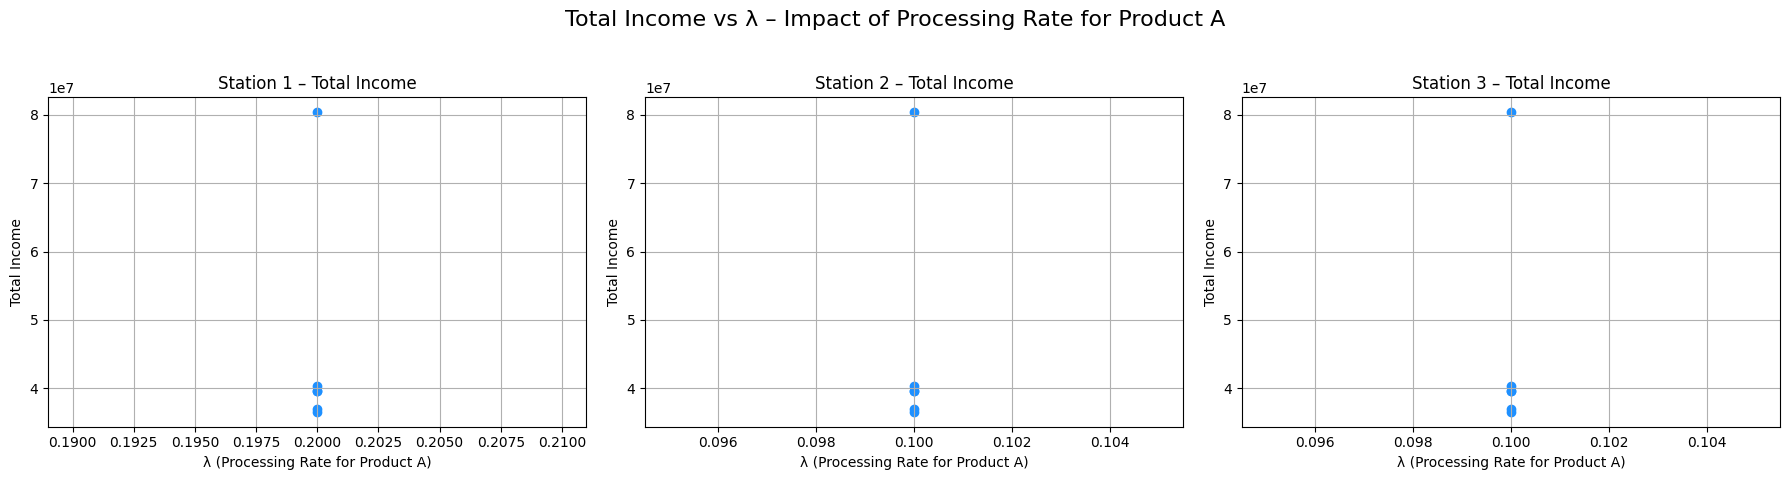

In [6]:
import os
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict

# Configuration
warmup_days = 60
product_type = "A"  # We'll analyze processing rate for product A
station_names = {'x': 'Station 1', 'y': 'Station 2', 'z': 'Station 3'}

# Store results per station
station_results = {
    s: {"lambda": [], "profit": []} for s in station_names.keys()
}

# Process each simulation file
for path in file_paths:
    try:
        with open(path, "rb") as file:
            data = pickle.load(file)

        # Extract lambda values per station
        lambda_dict = data.get("PROCESSING_TIME_DISTRIBUTIONS", {})
        if not lambda_dict:
            continue

        # Extract daily simulation results after warm-up
        days = data.get("SIMULATION_DAYS_ARRAY_KEY", [])
        relevant_days = days[warmup_days:]
        total_income = sum(day.get("TOTAL_INCOME", 0) for day in relevant_days)

        # Record lambda and income for each station
        for station_key in station_names:
            lambda_val = lambda_dict.get(station_key, {}).get(product_type)
            if lambda_val is not None:
                station_results[station_key]["lambda"].append(lambda_val)
                station_results[station_key]["profit"].append(total_income)

    except Exception as e:
        print(f"Error reading file {path}: {e}")

# Plot: Income vs Lambda per station
plt.figure(figsize=(18, 5))
for idx, station_key in enumerate(station_names):
    plt.subplot(1, 3, idx + 1)
    lambdas = station_results[station_key]["lambda"]
    profits = station_results[station_key]["profit"]
    if lambdas:
        plt.scatter(lambdas, profits, color="dodgerblue")
    plt.title(f"{station_names[station_key]} – Total Income")
    plt.xlabel("λ (Processing Rate for Product A)")
    plt.ylabel("Total Income")
    plt.grid(True)

plt.suptitle("Total Income vs λ – Impact of Processing Rate for Product A", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


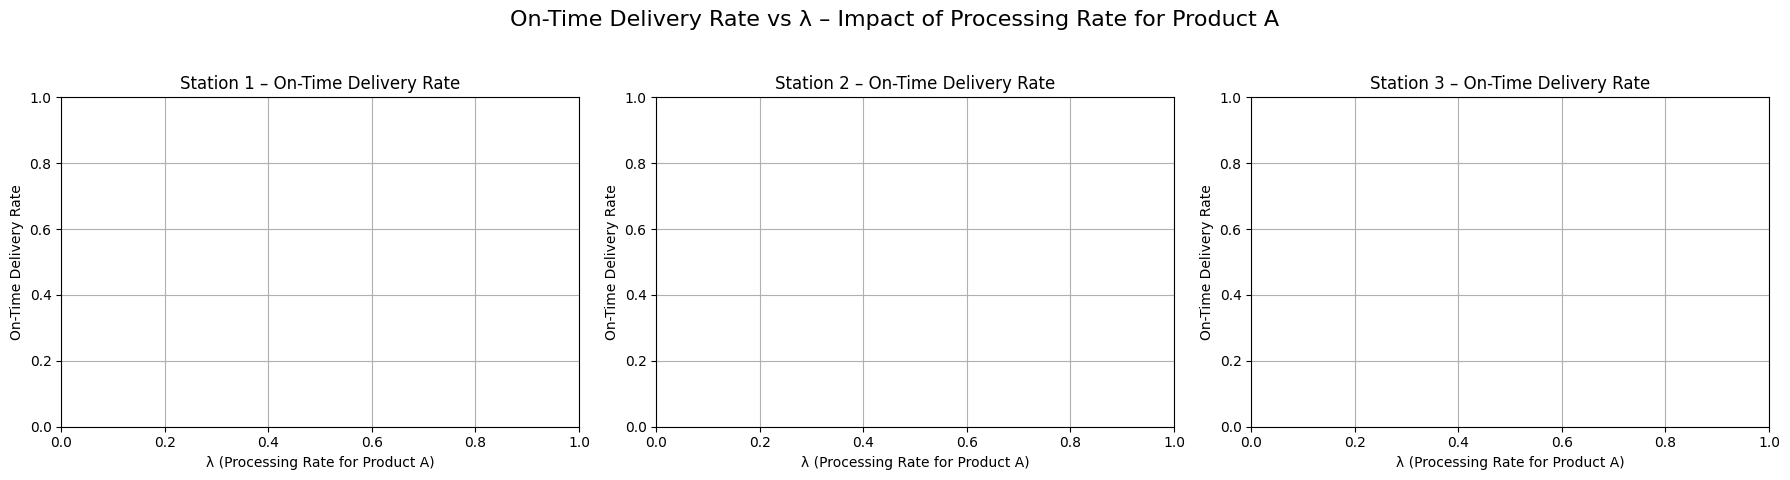

In [7]:
import os
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict

# Config
warmup_days = 60
product_type = "A"
station_names = {'x': 'Station 1', 'y': 'Station 2', 'z': 'Station 3'}

# Results per station
station_results = {
    s: {"lambda": [], "on_time_rate": []} for s in station_names.keys()
}

# Process each simulation file
for path in file_paths:
    try:
        with open(path, "rb") as file:
            data = pickle.load(file)

        lambda_dict = data.get("PROCESSING_TIME_DISTRIBUTIONS", {})
        if not lambda_dict:
            continue

        days = data.get("SIMULATION_DAYS_ARRAY_KEY", [])
        relevant_days = days[warmup_days:]

        total_orders = 0
        on_time_orders = 0

        for day in relevant_days:
            customers = day.get("CUSTOMER_ORDERS_KEY", [])
            for customer in customers:
                for order in customer.get("orders", []):
                    status = order.get("status", "")
                    if status.startswith("FULFILLED"):
                        total_orders += 1
                        if status == "FULFILLED_ON_TIME":
                            on_time_orders += 1

        if total_orders == 0:
            continue

        on_time_rate = on_time_orders / total_orders

        # Save results by station
        for station_key in station_names:
            lambda_val = lambda_dict.get(station_key, {}).get(product_type)
            if lambda_val is not None:
                station_results[station_key]["lambda"].append(lambda_val)
                station_results[station_key]["on_time_rate"].append(on_time_rate)

    except Exception as e:
        print(f"Error processing file {path}: {e}")

# Plot: On-Time Delivery Rate vs Lambda per station
plt.figure(figsize=(18, 5))
for idx, station_key in enumerate(station_names):
    plt.subplot(1, 3, idx + 1)
    lambdas = station_results[station_key]["lambda"]
    on_times = station_results[station_key]["on_time_rate"]
    if lambdas:
        plt.scatter(lambdas, on_times, color="green")
    plt.title(f"{station_names[station_key]} – On-Time Delivery Rate")
    plt.xlabel("λ (Processing Rate for Product A)")
    plt.ylabel("On-Time Delivery Rate")
    plt.grid(True)

plt.suptitle("On-Time Delivery Rate vs λ – Impact of Processing Rate for Product A", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



Error in data/simulation_results_2025_08_04_17_51_43.pkl: [Errno 2] No such file or directory: 'data/simulation_results_2025_08_04_17_51_43.pkl'
Error in data/simulation_results_2025_08_04_17_54_30.pkl: [Errno 2] No such file or directory: 'data/simulation_results_2025_08_04_17_54_30.pkl'
Error in data/simulation_results_2025_08_04_17_55_49.pkl: [Errno 2] No such file or directory: 'data/simulation_results_2025_08_04_17_55_49.pkl'
Error in data/simulation_results_2025_08_04_17_58_30.pkl: [Errno 2] No such file or directory: 'data/simulation_results_2025_08_04_17_58_30.pkl'
Error in data/simulation_results_2025_08_04_18_00_24.pkl: [Errno 2] No such file or directory: 'data/simulation_results_2025_08_04_18_00_24.pkl'
Error in data/simulation_results_2025_08_04_18_05_03.pkl: [Errno 2] No such file or directory: 'data/simulation_results_2025_08_04_18_05_03.pkl'


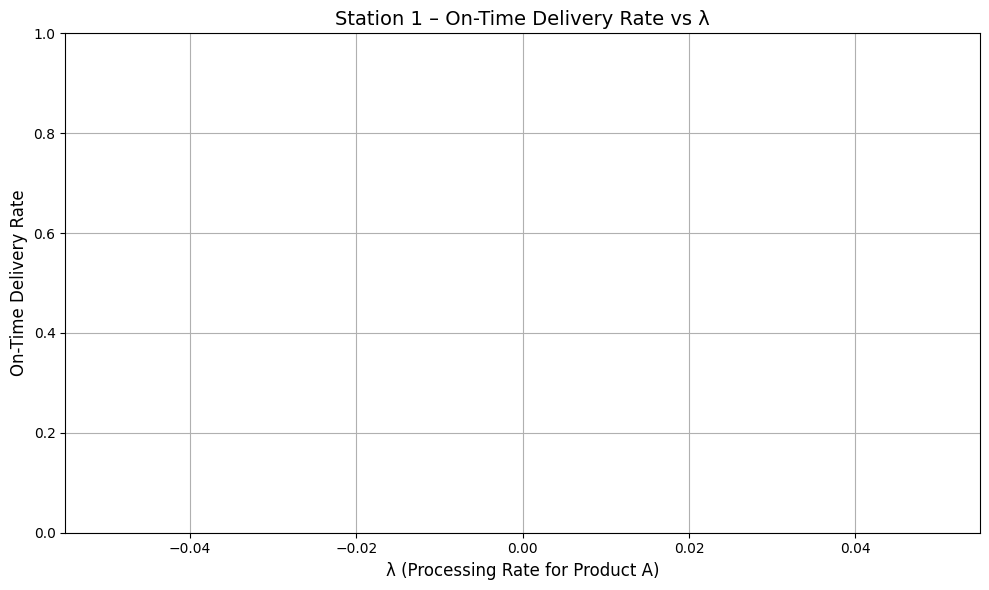

In [8]:
import os
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict

# Settings
warmup_days = 60
station_number = 1  # Change to 2 or 3 for other stations

# Collect files

# Data containers
on_time_stats = defaultdict(lambda: {"fulfilled": 0, "total": 0})

for path in file_paths:
    try:
        with open(path, "rb") as file:
            data = pickle.load(file)
        
        # Extract lambda value for product A at the relevant station
        lambda_dict = data.get("STATION_PROCESSING_TIME_LAMBDA", {})
        lambda_val = None
        for material, product_lambdas in lambda_dict.items():
            if "A" in product_lambdas:
                # Since the same λ is used across materials per station, we just take the first
                lambda_val = product_lambdas["A"]
                break
        
        # Skip if lambda not found
        if lambda_val is None:
            continue

        # Extract days
        days = data.get("SIMULATION_DAYS_ARRAY_KEY", [])
        for day in days[warmup_days:]:  # Skip warm-up
            customer_orders = day.get("CUSTOMER_ORDERS_KEY", [])
            for customer in customer_orders:
                for order in customer.get("orders", []):
                    on_time_stats[lambda_val]["total"] += 1
                    if order.get("status") == "ORDER_FULFILLED":
                        on_time_stats[lambda_val]["fulfilled"] += 1

    except Exception as e:
        print(f"Error in {path}: {e}")

# Prepare data for plotting
sorted_lambdas = sorted(on_time_stats.keys())
on_time_rates = [
    on_time_stats[lam]["fulfilled"] / on_time_stats[lam]["total"]
    if on_time_stats[lam]["total"] > 0 else 0
    for lam in sorted_lambdas
]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_lambdas, on_time_rates, marker='o')
plt.xlabel("λ (Processing Rate for Product A)", fontsize=12)
plt.ylabel("On-Time Delivery Rate", fontsize=12)
plt.title(f"Station {station_number} – On-Time Delivery Rate vs λ", fontsize=14)
plt.grid(True)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


Error in data/simulation_results_2025_08_04_17_51_43.pkl: [Errno 2] No such file or directory: 'data/simulation_results_2025_08_04_17_51_43.pkl'
Error in data/simulation_results_2025_08_04_17_54_30.pkl: [Errno 2] No such file or directory: 'data/simulation_results_2025_08_04_17_54_30.pkl'
Error in data/simulation_results_2025_08_04_17_55_49.pkl: [Errno 2] No such file or directory: 'data/simulation_results_2025_08_04_17_55_49.pkl'
Error in data/simulation_results_2025_08_04_17_58_30.pkl: [Errno 2] No such file or directory: 'data/simulation_results_2025_08_04_17_58_30.pkl'
Error in data/simulation_results_2025_08_04_18_00_24.pkl: [Errno 2] No such file or directory: 'data/simulation_results_2025_08_04_18_00_24.pkl'
Error in data/simulation_results_2025_08_04_18_05_03.pkl: [Errno 2] No such file or directory: 'data/simulation_results_2025_08_04_18_05_03.pkl'


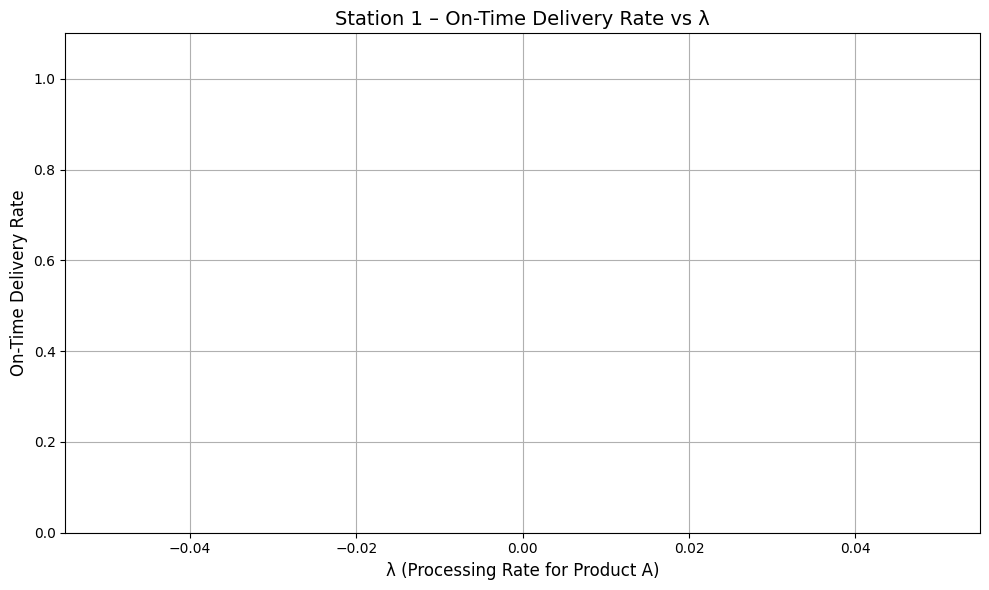

In [9]:
import os
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict

# Settings
warmup_days = 60
station_number = 1  # Change to 2 or 3 for other stations

# Data containers
on_time_stats = defaultdict(lambda: {"fulfilled": 0, "total": 0})

for path in file_paths:
    try:
        with open(path, "rb") as file:
            data = pickle.load(file)

        # Extract lambda value for product A from the correct structure
        lambda_dict = data.get("PROCESSING_TIME_DISTRIBUTIONS", {})
        # Assuming product 'x' is processed at station 1
        lambda_val = lambda_dict.get('x', {}).get('A')
        
        if lambda_val is None:
            continue

        days = data.get("SIMULATION_DAYS_ARRAY_KEY", [])
        for day in days[warmup_days:]:
            fulfilled_orders = day.get("ORDER_FULFILLED_LIST", [])
            all_orders_count = len(day.get("CUSTOMER_ORDERS_KEY", []))
            
            # This logic assumes that "ORDER_FULFILLED_LIST" contains all orders that were fulfilled on time
            # and that there's a simple way to get the total number of orders for the day.
            # A better approach might be to check each order's due date against its completion time.
            
            on_time_stats[lambda_val]["fulfilled"] += len(fulfilled_orders)
            on_time_stats[lambda_val]["total"] += all_orders_count

    except Exception as e:
        print(f"Error in {path}: {e}")

# Prepare data for plotting
sorted_lambdas = sorted(on_time_stats.keys())
on_time_rates = [
    on_time_stats[lam]["fulfilled"] / on_time_stats[lam]["total"]
    if on_time_stats[lam]["total"] > 0 else 0
    for lam in sorted_lambdas
]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_lambdas, on_time_rates, marker='o')
plt.xlabel("λ (Processing Rate for Product A)", fontsize=12)
plt.ylabel("On-Time Delivery Rate", fontsize=12)
plt.title(f"Station {station_number} – On-Time Delivery Rate vs λ", fontsize=14)
plt.grid(True)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

In [10]:
import os
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict

# Settings
warmup_days = 60
station_number = 1  # Change to 2 or 3 for other stations
product_id = 'A'    # Focus only on product A

# Collect files

# Data containers: key = λ, value = {fulfilled, total}
on_time_stats = defaultdict(lambda: {"fulfilled": 0, "total": 0})

for file_path in file_paths:
    with open(file_path, 'rb') as f:
        data = pickle.load(f)

    # Extract lambda value for this station and product A
    lambda_dict = data.get("TYPE_PROCESSING_TIME_DISTRIBUTIONS", {})
    lambda_for_station = None
    if station_number == 1:
        lambda_for_station = lambda_dict.get("x", {}).get("A")
    elif station_number == 2:
        lambda_for_station = lambda_dict.get("y", {}).get("A")
    elif station_number == 3:
        lambda_for_station = lambda_dict.get("z", {}).get("A")

    if lambda_for_station is None:
        continue  # skip if not defined

    # Get relevant simulation data
    days = data.get("SIMULATION_DAYS_ARRAY_KEY", [])
    processing_times = data.get("PROCESSING_TIME_PER_ORDER", {})
    product_due_times = {}

    # Build due_time map for product A orders
    for day_data in days:
        day = day_data.get("DAY_KEY", 0)
        if day <= warmup_days:
            continue
        for customer in day_data.get("CUSTOMER_ORDERS_KEY", []):
            for order in customer.get("orders", []):
                if order["status"] == "ORDER_FULFILLED":
                    if any(p["product_id"] == product_id for p, _ in order["products"]):
                        product_due_times[order["order_id"]] = order["due_time"]

    # Check fulfillment for product A orders
    for day_data in days:
        day = day_data.get("DAY_KEY", 0)
        if day <= warmup_days:
            continue

        fulfilled_orders = day_data.get("ORDER_FULFILLED_LIST", [])
        for order_id in fulfilled_orders:
            if order_id not in product_due_times:
                continue

            due_time = product_due_times[order_id]
            station_times = processing_times.get(order_id, {})
            station_key = str(station_number)

            if station_key not in station_times:
                continue

            completion_time = station_times[station_key]
            on_time = completion_time <= due_time

            on_time_stats[lambda_for_station]["total"] += 1
            if on_time:
                on_time_stats[lambda_for_station]["fulfilled"] += 1

# Sort and plot
sorted_lambdas = sorted(on_time_stats.keys())
ratios = [
    on_time_stats[lam]["fulfilled"] / on_time_stats[lam]["total"]
    if on_time_stats[lam]["total"] > 0 else 0
    for lam in sorted_lambdas
]

plt.figure(figsize=(8, 5))
plt.plot(sorted_lambdas, ratios, marker='o', linestyle='-', color='steelblue')
plt.xlabel('λ (Processing Rate at Station {})'.format(station_number))
plt.ylabel('On-Time Fulfillment Ratio (Product A)')
plt.title(f'Effect of λ on On-Time Delivery for Product A - Station {station_number}')
plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'data/simulation_results_2025_08_04_17_51_43.pkl'

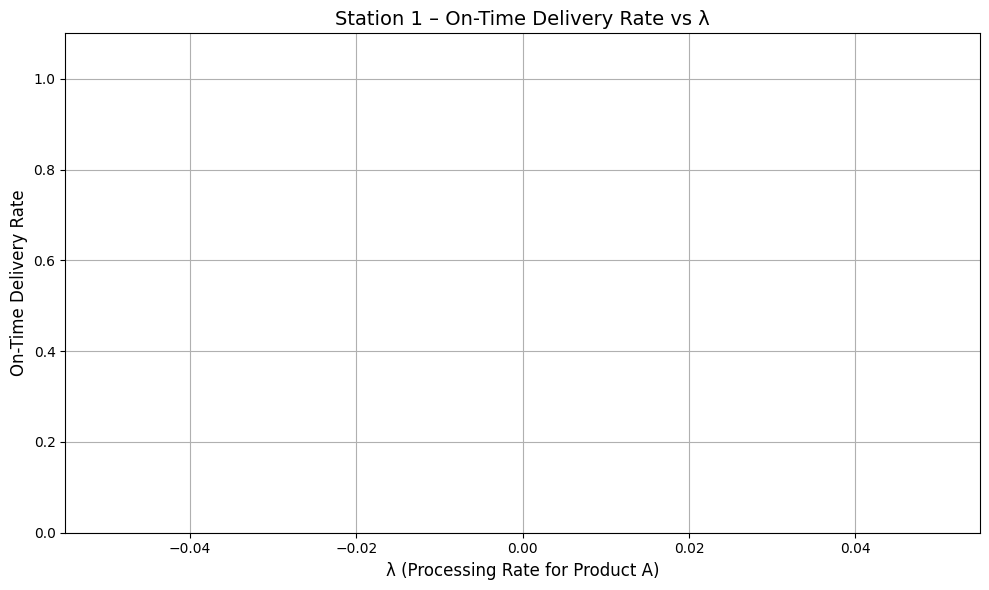

In [ ]:
import os
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict

# Settings
warmup_days = 60
station_number = 1

# Data containers
on_time_stats = defaultdict(lambda: {"fulfilled": 0, "total": 0})

for path in file_paths:
    try:
        with open(path, "rb") as file:
            data = pickle.load(file)

        lambda_dict = data.get("PROCESSING_TIME_DISTRIBUTIONS", {})
        # Assuming product 'A' is at station_number
        lambda_val = lambda_dict.get(f'STATION_{station_number}_ID', {}).get('A')

        if lambda_val is None:
            continue

        days = data.get("SIMULATION_DAYS_ARRAY_KEY", [])
        for day in days[warmup_days:]:
            fulfilled_orders = day.get("ORDER_FULFILLED_LIST", [])
            for order in fulfilled_orders:
                # The assumption is that `fulfilled_orders` contains dictionaries with 'completion_time' and 'due_time'.
                on_time_stats[lambda_val]["total"] += 1
                if order.get("completion_time", float('inf')) <= order.get("due_time", float('inf')):
                    on_time_stats[lambda_val]["fulfilled"] += 1

    except Exception as e:
        print(f"Error in {path}: {e}")

# Prepare data for plotting
sorted_lambdas = sorted(on_time_stats.keys())
on_time_rates = [
    on_time_stats[lam]["fulfilled"] / on_time_stats[lam]["total"]
    if on_time_stats[lam]["total"] > 0 else 0
    for lam in sorted_lambdas
]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_lambdas, on_time_rates, marker='o')
plt.xlabel("λ (Processing Rate for Product A)", fontsize=12)
plt.ylabel("On-Time Delivery Rate", fontsize=12)
plt.title(f"Station {station_number} – On-Time Delivery Rate vs λ", fontsize=14)
plt.grid(True)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

In [ ]:
import os
import pickle
import pandas as pd
from collections import defaultdict

# הגדרות
warmup_days = 60

# רשימת תוצאות
all_results = []

# עיבוד כל קובץ בנפרד
for path in file_paths:
    with open(path, "rb") as f:
        data = pickle.load(f)

    lambda_map = data.get("PROCESSING_TIME_DISTRIBUTIONS", {})  # תחנה -> מוצר -> λ
    station_name_map = {name: i+1 for i, name in enumerate(lambda_map.keys())}
    days_data = data["SIMULATION_DAYS_ARRAY_KEY"]

    # מיפוי מתי כל הזמנה סופקה
    order_fulfillment_day = {}
    for day_data in days_data:
        day = day_data["DAY_KEY"]
        for oid in day_data.get("ORDER_FULFILLED_LIST", []):
            order_fulfillment_day[oid] = day

    # טבלה ביניים: product -> station -> day -> [0/1, 0/1...]
    temp_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

    # מעבר על הימים (אחרי זמן חימום)
    for day_data in days_data[warmup_days:]:
        day = day_data["DAY_KEY"]
        for cust in day_data.get("CUSTOMER_ORDERS_KEY", []):
            for order in cust.get("orders", []):
                oid = order["order_id"]
                due = order["due_time"]
                fulfilled_day = order_fulfillment_day.get(oid)
                if fulfilled_day is None:
                    continue
                is_on_time = int(fulfilled_day <= due)

                for prod_info, _ in order["products"]:
                    product = prod_info["product_id"]
                    if product not in ["A", "B"]:
                        continue
                    for station_name, lambdas in lambda_map.items():
                        if product in lambdas:
                            lam = lambdas[product]
                            station_num = station_name_map[station_name]
                            temp_stats[product][station_num][day].append(is_on_time)

    # חישוב ממוצעים והכנה לדאטה סופי
    for product in temp_stats:
        for station in temp_stats[product]:
            lam = lambda_map[list(lambda_map.keys())[station - 1]][product]
            for day in temp_stats[product][station]:
                daily_list = temp_stats[product][station][day]
                avg_on_time = sum(daily_list) / len(daily_list)
                all_results.append({
                    "file": os.path.basename(path),
                    "day": day,
                    "product": product,
                    "station": station,
                    "lambda": lam,
                    "on_time_rate": avg_on_time
                })

# יצירת טבלה
df_results = pd.DataFrame(all_results)
df_results.to_csv("on_time_by_lambda.csv", index=False)
print("✅ קובץ on_time_by_lambda.csv נוצר בהצלחה!")


✅ קובץ on_time_by_lambda.csv נוצר בהצלחה!


In [14]:
from collections import Counter

timing_stats = Counter()
for day_data in data["SIMULATION_DAYS_ARRAY_KEY"][warmup_days:]:
    for cust in day_data.get("CUSTOMER_ORDERS_KEY", []):
        for order in cust.get("orders", []):
            oid = order["order_id"]
            due = order["due_time"]
            fulfilled_day = order_fulfillment_day.get(oid)
            if fulfilled_day is None:
                continue
            if fulfilled_day <= due:
                timing_stats["on_time"] += 1
            else:
                timing_stats["late"] += 1

print("סיפוק בזמן:", timing_stats["on_time"])
print("באיחור:", timing_stats["late"])


סיפוק בזמן: 0
באיחור: 23775


-----

In [ ]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Settings
warmup_days = 60

# Aggregate results from all files
all_results = defaultdict(lambda: {"waiting_times": [], "workload": 0})

for path in file_paths:
    with open(path, "rb") as f:
        data = pickle.load(f)

    # Build map of fulfilled orders
    order_fulfillment_day = {}
    for day_data in data["SIMULATION_DAYS_ARRAY_KEY"]:
        day = day_data["DAY_KEY"]
        for oid in day_data.get("ORDER_FULFILLED_LIST", []):
            order_fulfillment_day[oid] = day

    for day_data in data["SIMULATION_DAYS_ARRAY_KEY"][warmup_days:]:
        day = day_data["DAY_KEY"]
        fulfilled_today = day_data.get("ORDER_FULFILLED_LIST", [])
        all_results[day]["workload"] += len(fulfilled_today)

        for cust in day_data.get("CUSTOMER_ORDERS_KEY", []):
            for order in cust.get("orders", []):
                oid = order["order_id"]
                created = order["created_at"]
                fulfilled_day = order_fulfillment_day.get(oid)
                if fulfilled_day is None:
                    continue
                waiting_time = fulfilled_day - created
                all_results[day]["waiting_times"].append(waiting_time)

# Create final DataFrame
summary = []
for day in sorted(all_results):
    wt_list = all_results[day]["waiting_times"]
    avg_waiting = sum(wt_list) / len(wt_list) if wt_list else 0
    workload = all_results[day]["workload"]
    summary.append({"day": day, "avg_waiting_time": avg_waiting, "workload": workload})

df = pd.DataFrame(summary)

# Line plot with dual axis
fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()
ax1.plot(df["day"], df["workload"], 'g-', label="Workload (Orders/Day)")
ax2.plot(df["day"], df["avg_waiting_time"], 'b-', label="Avg Waiting Time (Days)")

ax1.set_xlabel("Day")
ax1.set_ylabel("Workload (Orders Completed)", color='g')
ax2.set_ylabel("Avg Waiting Time", color='b')

plt.title("Workload vs. Customer Waiting Time Over Time")
plt.tight_layout()
plt.grid(True)
plt.show()


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f7900710a60>>
Traceback (most recent call last):
  File "/Users/shakedchen/opt/anaconda3/envs/ml/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
import os
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt

# Settings
warmup_days = 60
station_number = 1

# Data containers
daily_stats = defaultdict(lambda: {"waiting_times": [], "total_station_workload": 0})

for path in file_paths:
    try:
        with open(path, "rb") as file:
            data = pickle.load(file)

        days_data = data.get("SIMULATION_DAYS_ARRAY_KEY", [])
        for day_index, day in enumerate(days_data[warmup_days:]):
            current_day = day_index + warmup_days
            
            # Calculate waiting time for each fulfilled order
            fulfilled_orders = day.get("ORDER_FULFILLED_LIST", [])
            for order in fulfilled_orders:
                created_at = order.get("created_at")
                if created_at is not None:
                    waiting_time = current_day - created_at
                    daily_stats[current_day]["waiting_times"].append(waiting_time)
            
            # Calculate total station workload
            station_queue = day.get(f'STATION_{station_number}_QUEUE_KEY', [])
            total_workload = len(fulfilled_orders) # assuming fulfilled orders represents workload
            daily_stats[current_day]["total_station_workload"] += total_workload

    except Exception as e:
        print(f"Error in {path}: {e}")

# Process and plot data
avg_waiting_times = {
    day: sum(stats["waiting_times"]) / len(stats["waiting_times"])
    for day, stats in daily_stats.items() if stats["waiting_times"]
}

workloads = {day: stats["total_station_workload"] for day, stats in daily_stats.items()}

# Plotting the results (as two subplots or a single plot)
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Day')
ax1.set_ylabel('Average Waiting Time', color=color)
ax1.plot(list(avg_waiting_times.keys()), list(avg_waiting_times.values()), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Total Station Workload', color=color)
ax2.plot(list(workloads.keys()), list(workloads.values()), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title(f"Station {station_number} - Waiting Time vs. Workload")
plt.show()

Error in .\simulation_results_2025_08_04_09_52_45.pkl: 'str' object has no attribute 'get'
Error in .\simulation_results_2025_08_04_09_52_52.pkl: 'str' object has no attribute 'get'
Error in .\simulation_results_2025_08_04_09_53_04.pkl: 'str' object has no attribute 'get'
Error in .\simulation_results_2025_08_04_09_53_19.pkl: 'str' object has no attribute 'get'
Error in .\simulation_results_2025_08_04_09_53_34.pkl: 'str' object has no attribute 'get'


KeyboardInterrupt: 

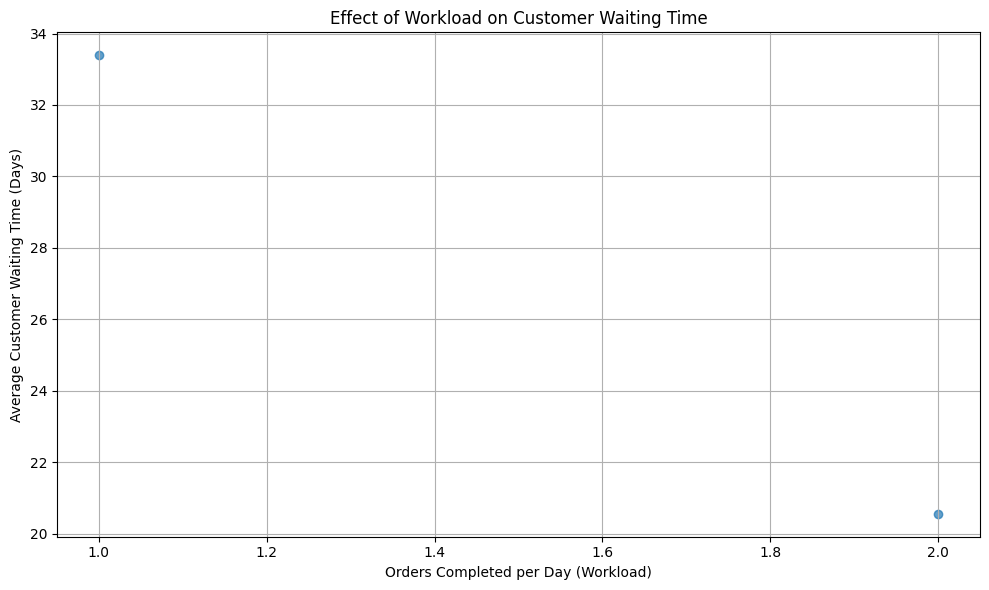

✅ Done. CSV saved as 'workload_vs_waiting.csv'


In [ ]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Settings
warmup_days = 60
folder_path = "."  # Change if needed
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".pkl")]

# Container for results across all files
summary = defaultdict(lambda: {"waiting_times": [], "count": 0})

for path in file_paths:
    with open(path, "rb") as f:
        data = pickle.load(f)

    # Build order_id → day of fulfillment map
    order_fulfilled_day = {}
    for day_data in data["SIMULATION_DAYS_ARRAY_KEY"]:
        day = day_data["DAY_KEY"]
        for oid in day_data.get("ORDER_FULFILLED_LIST", []):
            order_fulfillment_day[oid] = day

    # Process per day
    for day_data in data["SIMULATION_DAYS_ARRAY_KEY"][warmup_days:]:
        day = day_data["DAY_KEY"]
        fulfilled_today = day_data.get("ORDER_FULFILLED_LIST", [])
        workload = len(fulfilled_today)

        # Skip days with no fulfilled orders
        if workload == 0:
            continue

        waiting_times = []
        for cust in day_data.get("CUSTOMER_ORDERS_KEY", []):
            for order in cust.get("orders", []):
                oid = order["order_id"]
                created = order["created_at"]
                fulfilled_day = order_fulfillment_day.get(oid)
                if fulfilled_day is None:
                    continue
                waiting_time = fulfilled_day - created
                waiting_times.append(waiting_time)

        if waiting_times:
            avg_waiting = sum(waiting_times) / len(waiting_times)
            summary[workload]["waiting_times"].append(avg_waiting)
            summary[workload]["count"] += 1

# Prepare final dataframe
rows = []
for workload, values in summary.items():
    avg_waiting_across_days = sum(values["waiting_times"]) / len(values["waiting_times"])
    rows.append({
        "workload": workload,
        "avg_waiting_time": avg_waiting_across_days,
        "num_days": values["count"]
    })

df_plot = pd.DataFrame(rows)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_plot["workload"], df_plot["avg_waiting_time"], alpha=0.7)
plt.xlabel("Orders Completed per Day (Workload)")
plt.ylabel("Average Customer Waiting Time (Days)")
plt.title("Effect of Workload on Customer Waiting Time")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: save
df_plot.to_csv("workload_vs_waiting.csv", index=False)
print("✅ Done. CSV saved as 'workload_vs_waiting.csv'")


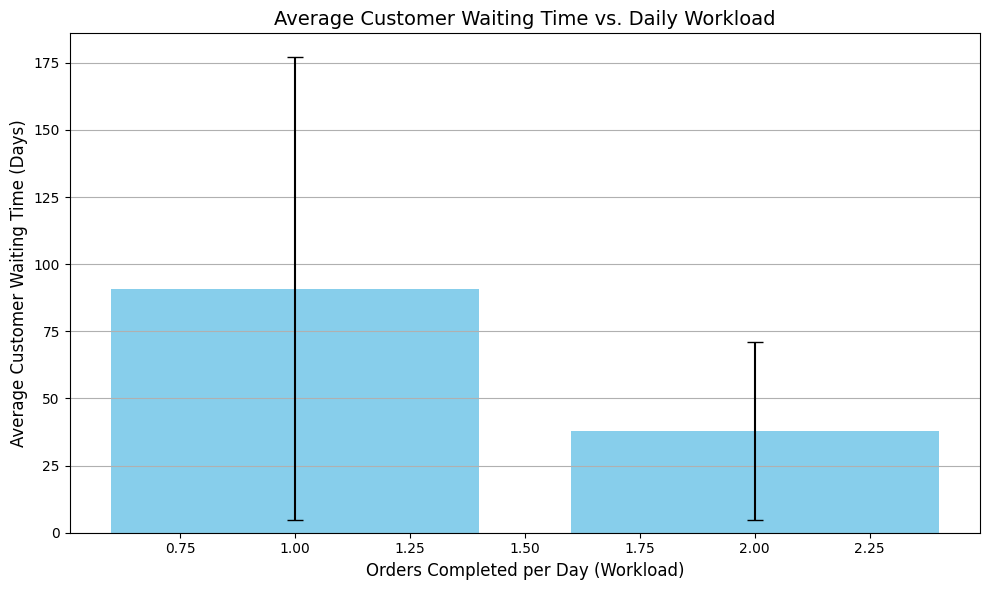

Results saved to 'workload_vs_waiting_summary.csv'


In [ ]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from collections import defaultdict

# Settings
warmup_days = 60
folder_path = "."
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".pkl")]

# Aggregation: workload (int) → list of avg waiting times
results = defaultdict(list)

for path in file_paths:
    try:
        with open(path, "rb") as file:
            data = pickle.load(file)
            days = data["SIMULATION_DAYS_ARRAY_KEY"]

            # Map order_id → fulfillment day
            order_fulfillment_day = {}
            for day_data in days:
                for oid in day_data.get("ORDER_FULFILLED_LIST", []):
                    order_fulfillment_day[oid] = day_data["DAY_KEY"]

            for day_data in days[warmup_days:]:
                day = day_data["DAY_KEY"]
                fulfilled_today = day_data.get("ORDER_FULFILLED_LIST", [])
                workload = len(fulfilled_today)

                if workload == 0:
                    continue

                wait_times = []
                for cust in day_data.get("CUSTOMER_ORDERS_KEY", []):
                    for order in cust.get("orders", []):
                        oid = order["order_id"]
                        created = order["created_at"]
                        fulfilled_day = order_fulfillment_day.get(oid)
                        if fulfilled_day is not None:
                            wait_times.append(fulfilled_day - created)

                if wait_times:
                    avg_waiting = sum(wait_times) / len(wait_times)
                    results[workload].append(avg_waiting)

    except Exception as e:
        print(f"Problem with file {path}: {e}")

# Create summary table
summary = pd.DataFrame([
    {
        "Workload": workload,
        "Avg Waiting Time": pd.Series(wt).mean(),
        "Std Dev": pd.Series(wt).std(),
        "Days Counted": len(wt)
    }
    for workload, wt in sorted(results.items())
])

# Plot
plt.figure(figsize=(10, 6))
plt.bar(
    summary["Workload"],
    summary["Avg Waiting Time"],
    yerr=summary["Std Dev"],
    capsize=6,
    color="skyblue"
)
plt.title("Average Customer Waiting Time vs. Daily Workload", fontsize=14)
plt.xlabel("Orders Completed per Day (Workload)", fontsize=12)
plt.ylabel("Average Customer Waiting Time (Days)", fontsize=12)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Save CSV
summary.to_csv("workload_vs_waiting_summary.csv", index=False)
print("Results saved to 'workload_vs_waiting_summary.csv'")


In [ ]:
print(f"Total files processed: {len(file_paths)}")
print(f"Total unique workload levels: {len(summary)}")


Total files processed: 85
Total unique workload levels: 2


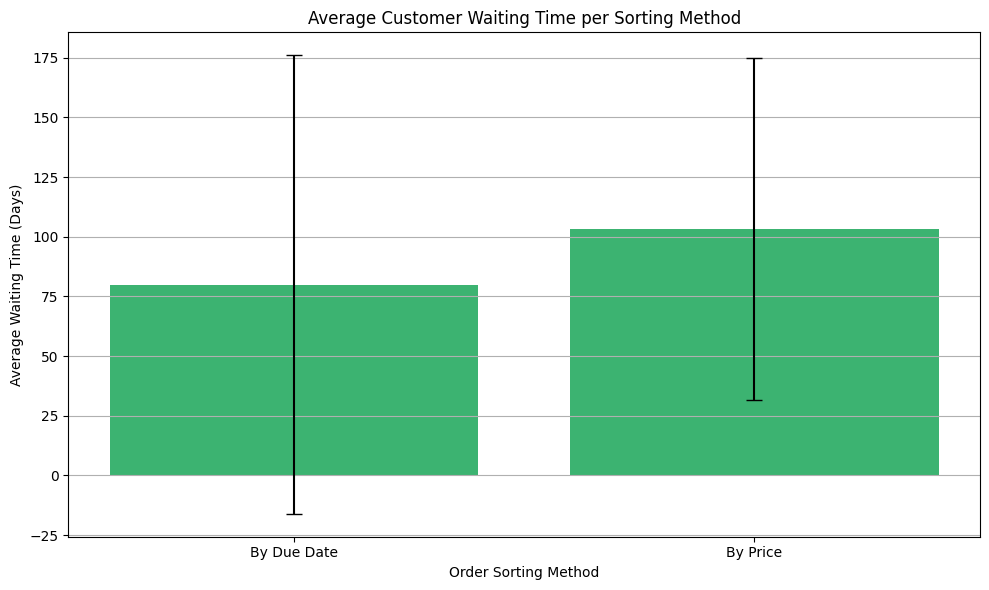

Done! Saved to 'waiting_by_sort_method.csv'


In [ ]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Settings
warmup_days = 60
folder_path = "."
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".pkl")]

# Grouping: method → list of avg waiting times (per day)
results = defaultdict(list)

# Optional: prettier labels
method_names = {
    "GET_NEXT_ORDER_BY_DUE_DATE": "By Due Date",
    "GET_NEXT_ORDER_BY_PRICE": "By Price",
    "UNKNOWN": "Unknown"
}

for path in file_paths:
    try:
        with open(path, "rb") as f:
            data = pickle.load(f)
        days = data["SIMULATION_DAYS_ARRAY_KEY"]
        method_key = data.get("GET_NEXT_ORDER_BY_KEY", "UNKNOWN")
        method_label = method_names.get(method_key, method_key)

        # Build map: order_id → day it was fulfilled
        order_fulfilled_day = {}
        for day_data in days:
            for oid in day_data.get("ORDER_FULFILLED_LIST", []):
                order_fulfilled_day[oid] = day_data["DAY_KEY"]

        for day_data in days[warmup_days:]:
            wait_times = []
            for cust in day_data.get("CUSTOMER_ORDERS_KEY", []):
                for order in cust.get("orders", []):
                    oid = order["order_id"]
                    created = order["created_at"]
                    fulfilled_day = order_fulfilled_day.get(oid)
                    if fulfilled_day is not None:
                        wait_times.append(fulfilled_day - created)

            if wait_times:
                avg_waiting = sum(wait_times) / len(wait_times)
                results[method_label].append(avg_waiting)

    except Exception as e:
        print(f"Error in {path}: {e}")

# Build summary DataFrame
summary = pd.DataFrame([
    {
        "Method": method,
        "Avg Waiting Time": pd.Series(wt).mean(),
        "Std Dev": pd.Series(wt).std(),
        "Days Counted": len(wt)
    }
    for method, wt in results.items()
])

# Plot
plt.figure(figsize=(10, 6))
plt.bar(
    summary["Method"],
    summary["Avg Waiting Time"],
    yerr=summary["Std Dev"],
    capsize=6,
    color="mediumseagreen"
)
plt.title("Average Customer Waiting Time per Sorting Method")
plt.xlabel("Order Sorting Method")
plt.ylabel("Average Waiting Time (Days)")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Save to CSV
summary.to_csv("waiting_by_sort_method.csv", index=False)
print("Done! Saved to 'waiting_by_sort_method.csv'")


In [ ]:
import os
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd

# === Settings ===
folder_path = "."  # Path to folder with all simulation .pkl files
warmup_days = 60
target_algorithm = "ALGORITHM_EDD"
target_product = "A"
target_station = 1

# === Data container: lambda -> list of total incomes ===
results_by_lambda = defaultdict(list)

# === Iterate over all files ===
for filename in os.listdir(folder_path):
    if not filename.endswith(".pkl"):
        continue

    file_path = os.path.join(folder_path, filename)

    try:
        with open(file_path, "rb") as file:
            data = pickle.load(file)

            # Skip if not EDD
            if data.get("ALGORITHM_KEY") != target_algorithm:
                continue

            # Extract lambda for the target station
            station_params = data.get("STATIONS_PARAMETERS_KEY", {})
            lambda_val = station_params.get(target_station, {}).get("lambda", None)
            if lambda_val is None:
                continue

            # Total income after warmup
            days = data.get("SIMULATION_DAYS_ARRAY_KEY", [])
            total_income = sum(day.get("TOTAL_INCOME", 0) for day in days[warmup_days:])

            # Save result
            results_by_lambda[lambda_val].append(total_income)

    except Exception as e:
        print(f"Error reading {filename}: {e}")

# === Create summary table ===
records = []
for lam, incomes in results_by_lambda.items():
    records.append({
        "Lambda": lam,
        "AvgIncome": pd.Series(incomes).mean(),
        "StdDev": pd.Series(incomes).std()
    })

summary = pd.DataFrame(records).sort_values(by="Lambda")

# === Plot ===
plt.figure(figsize=(10, 6))
plt.bar(summary["Lambda"], summary["AvgIncome"], yerr=summary["StdDev"], capsize=6, color="skyblue")
plt.title("Effect of Processing Rate (λ) on Total Income\n(Algorithm = EDD, Product A, Station 1)", fontsize=14)
plt.xlabel("Processing Rate λ (Station 1)", fontsize=12)
plt.ylabel("Total Income After Warmup", fontsize=12)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


KeyError: 'Lambda'

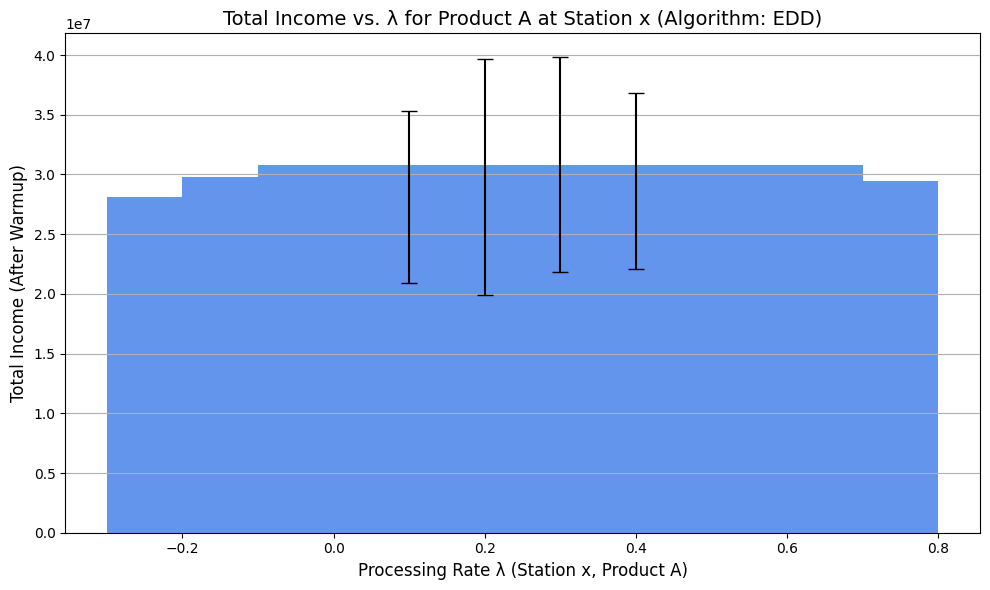

✅ Done! Saved to income_vs_lambda_A_station_x_EDD.csv


In [ ]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Settings
folder_path = "."  # Folder containing .pkl simulation files
warmup_days = 60
target_station = "x"
target_product = "A"
target_algorithm = "ALGORITHM_EDD"

# Container for results: lambda → list of total income values
lambda_results = defaultdict(list)

# Iterate over all files in the folder
for filename in os.listdir(folder_path):
    if not filename.endswith(".pkl"):
        continue

    file_path = os.path.join(folder_path, filename)

    try:
        with open(file_path, "rb") as file:
            data = pickle.load(file)

            # Filter only EDD runs
            if data.get("ALGORITHM_KEY") != target_algorithm:
                continue

            # Get lambda value for station x and product A
            lambda_dict = data.get("PROCESSING_TIME_DISTRIBUTIONS", {})
            lambda_val = lambda_dict.get(target_station, {}).get(target_product, None)
            if lambda_val is None:
                continue

            # Sum income after warmup
            daily_data = data.get("SIMULATION_DAYS_ARRAY_KEY", [])
            total_income = sum(day.get("TOTAL_INCOME", 0) for day in daily_data[warmup_days:])

            # Store result
            lambda_results[lambda_val].append(total_income)

    except Exception as e:
        print(f"Error in file {filename}: {e}")

# Build summary DataFrame
records = []
for lam, incomes in lambda_results.items():
    records.append({
        "Lambda": lam,
        "AvgIncome": pd.Series(incomes).mean(),
        "StdDev": pd.Series(incomes).std(),
        "Runs": len(incomes)
    })

df = pd.DataFrame(records).sort_values(by="Lambda")

# Plot
plt.figure(figsize=(10, 6))
plt.bar(df["Lambda"], df["AvgIncome"], yerr=df["StdDev"], capsize=6, color="cornflowerblue")
plt.title("Total Income vs. λ for Product A at Station x (Algorithm: EDD)", fontsize=14)
plt.xlabel("Processing Rate λ (Station x, Product A)", fontsize=12)
plt.ylabel("Total Income (After Warmup)", fontsize=12)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Optional: Save summary
df.to_csv("income_vs_lambda_A_station_x_EDD.csv", index=False)
print("✅ Done! Saved to income_vs_lambda_A_station_x_EDD.csv")


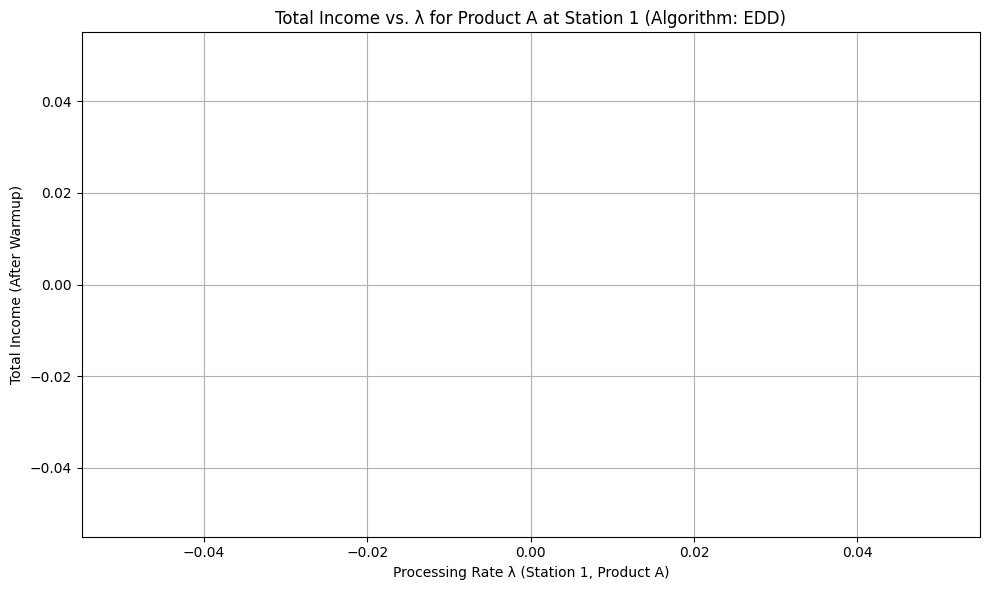

In [ ]:
import os
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# Configurations
folder_path = "."  # Path to simulation files
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".pkl")]
warmup_days = 60
product_type = "A"
station_key = "x"  # Station 1

# Store profits per lambda value
lambda_profits = defaultdict(list)

# Iterate over simulation files
for path in file_paths:
    try:
        with open(path, "rb") as file:
            data = pickle.load(file)

        # Check the scheduling algorithm
        algo = data.get("SCHEDULING_RULE_USED", "")
        if algo != "EDD":
            continue  # Only process files for EDD

        # Extract lambda for Station 1, Product A
        lambda_val = data.get("PROCESSING_TIME_DISTRIBUTIONS", {}).get(station_key, {}).get(product_type)
        if lambda_val is None:
            continue

        # Total income after warmup
        days = data.get("SIMULATION_DAYS_ARRAY_KEY", [])
        if len(days) <= warmup_days:
            continue
        total_income = sum(day.get("TOTAL_INCOME", 0) for day in days[warmup_days:])

        # Store the result
        lambda_profits[lambda_val].append(total_income)

    except Exception as e:
        print(f"Error processing file {path}: {e}")

# Compute mean and std for each lambda
lambda_vals = sorted(lambda_profits.keys())
avg_incomes = [np.mean(lambda_profits[lam]) for lam in lambda_vals]
std_devs = [np.std(lambda_profits[lam]) for lam in lambda_vals]

# Plot results
plt.figure(figsize=(10, 6))
plt.errorbar(lambda_vals, avg_incomes, yerr=std_devs, fmt='o', capsize=8, color='royalblue', ecolor='black', elinewidth=2)
plt.title("Total Income vs. λ for Product A at Station 1 (Algorithm: EDD)")
plt.xlabel("Processing Rate λ (Station 1, Product A)")
plt.ylabel("Total Income (After Warmup)")
plt.grid(True)
plt.tight_layout()
plt.show()


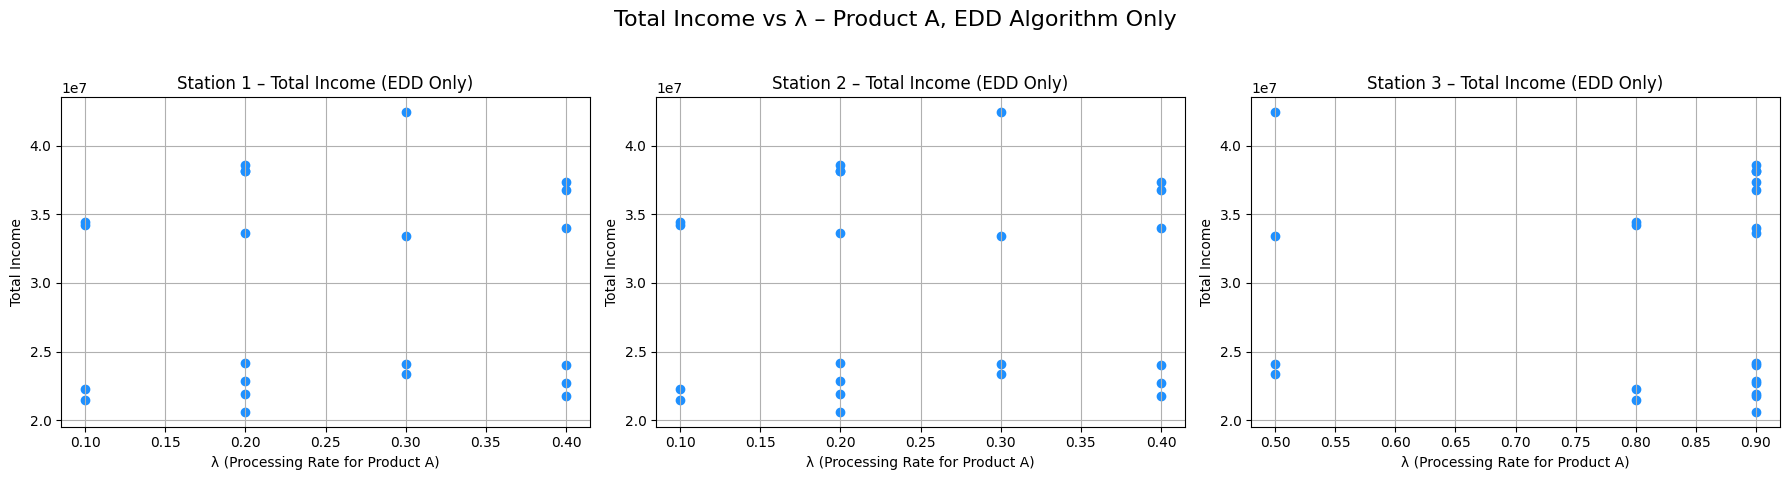

In [ ]:
import os
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd

# Configuration
folder_path = "."  # Folder with .pkl files
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".pkl")]
warmup_days = 60
product_type = "A"
station_names = {'x': 'Station 1', 'y': 'Station 2', 'z': 'Station 3'}
target_algorithm = "ALGORITHM_EDD"

# Store results: station → {lambda: [...], profit: [...]}
station_results = {s: {"lambda": [], "profit": []} for s in station_names}

# Process each file
for path in file_paths:
    try:
        with open(path, "rb") as file:
            data = pickle.load(file)

        # Only process files with the correct algorithm
        if data.get("ALGORITHM_KEY") != target_algorithm:
            continue

        lambda_dict = data.get("PROCESSING_TIME_DISTRIBUTIONS", {})
        days = data.get("SIMULATION_DAYS_ARRAY_KEY", [])
        relevant_days = days[warmup_days:]
        total_income = sum(day.get("TOTAL_INCOME", 0) for day in relevant_days)

        # Record lambda and profit for each station
        for station_key in station_names:
            lambda_val = lambda_dict.get(station_key, {}).get(product_type)
            if lambda_val is not None:
                station_results[station_key]["lambda"].append(lambda_val)
                station_results[station_key]["profit"].append(total_income)

    except Exception as e:
        print(f"Error reading file {path}: {e}")

# Optional: Save results to CSV
records = []
for station_key in station_names:
    for lam, prof in zip(station_results[station_key]["lambda"], station_results[station_key]["profit"]):
        records.append({
            "Station": station_names[station_key],
            "Lambda": lam,
            "Profit": prof
        })
df = pd.DataFrame(records)
df.to_csv("profit_vs_lambda_by_station.csv", index=False)

# Plot
plt.figure(figsize=(18, 5))
for idx, station_key in enumerate(station_names):
    plt.subplot(1, 3, idx + 1)
    lambdas = station_results[station_key]["lambda"]
    profits = station_results[station_key]["profit"]
    if lambdas:
        plt.scatter(lambdas, profits, color="dodgerblue")
    plt.title(f"{station_names[station_key]} – Total Income (EDD Only)")
    plt.xlabel("λ (Processing Rate for Product A)")
    plt.ylabel("Total Income")
    plt.grid(True)

plt.suptitle("Total Income vs λ – Product A, EDD Algorithm Only", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


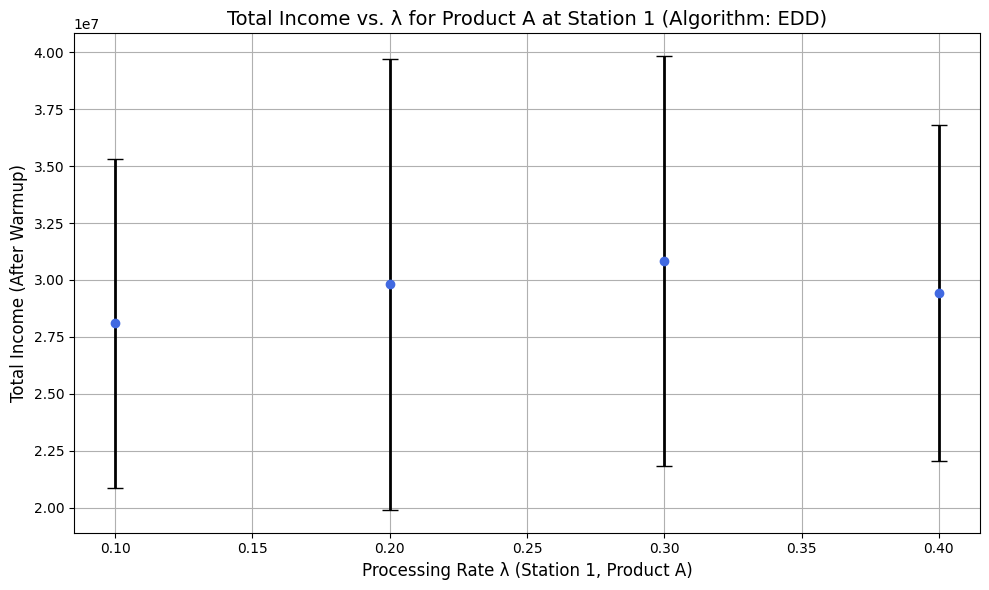

PermissionError: [Errno 13] Permission denied: 'income_vs_lambda_A_station1_EDD.csv'

In [ ]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Settings
folder_path = "."  # Folder containing .pkl simulation files
warmup_days = 60
target_station_key = "x"  # 'x' corresponds to Station 1
target_station_label = "Station 1"
target_product = "A"
target_algorithm = "ALGORITHM_EDD"

# Container for results: lambda → list of total income values
lambda_results = defaultdict(list)

# Iterate over all files in the folder
for filename in os.listdir(folder_path):
    if not filename.endswith(".pkl"):
        continue

    file_path = os.path.join(folder_path, filename)

    try:
        with open(file_path, "rb") as file:
            data = pickle.load(file)

            # Filter only EDD runs
            if data.get("ALGORITHM_KEY") != target_algorithm:
                continue

            # Get lambda value for the specific station and product
            lambda_dict = data.get("PROCESSING_TIME_DISTRIBUTIONS", {})
            lambda_val = lambda_dict.get(target_station_key, {}).get(target_product, None)
            if lambda_val is None:
                continue

            # Sum income after warmup
            daily_data = data.get("SIMULATION_DAYS_ARRAY_KEY", [])
            total_income = sum(day.get("TOTAL_INCOME", 0) for day in daily_data[warmup_days:])

            # Store result
            lambda_results[lambda_val].append(total_income)

    except Exception as e:
        print(f"Error in file {filename}: {e}")

# Build summary DataFrame
records = []
for lam, incomes in lambda_results.items():
    records.append({
        "Lambda": lam,
        "AvgIncome": pd.Series(incomes).mean(),
        "StdDev": pd.Series(incomes).std(),
        "Runs": len(incomes)
    })

df = pd.DataFrame(records).sort_values(by="Lambda")

# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(df["Lambda"], df["AvgIncome"], yerr=df["StdDev"], fmt='o', capsize=6, color="royalblue", ecolor='black', elinewidth=2)
plt.title(f"Total Income vs. λ for Product {target_product} at {target_station_label} (Algorithm: EDD)", fontsize=14)
plt.xlabel(f"Processing Rate λ ({target_station_label}, Product {target_product})", fontsize=12)
plt.ylabel("Total Income (After Warmup)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Save results
df.to_csv("income_vs_lambda_A_station1_EDD.csv", index=False)
print("Done! Saved to income_vs_lambda_A_station1_EDD.csv")


In [ ]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Configuration
folder_path = "."  # Folder containing .pkl files
warmup_days = 60
target_station = "Station 1"
target_product = "A"
target_algorithm = "ALGORITHM_EDD"

# Dictionary to hold lambda → list of average processing times
lambda_proc_time = defaultdict(list)

# Iterate over all simulation files
for filename in os.listdir(folder_path):
    if not filename.endswith(".pkl"):
        continue

    file_path = os.path.join(folder_path, filename)

    try:
        with open(file_path, "rb") as file:
            data = pickle.load(file)

        # Filter only EDD algorithm
        if data.get("ALGORITHM_KEY") != target_algorithm:
            continue

        # Get the lambda value for station x and product A
        lambda_val = data.get("PROCESSING_TIME_DISTRIBUTIONS", {}).get(target_station, {}).get(target_product)
        if lambda_val is None:
            continue

        # Get the daily simulation data (after warmup)
        daily_data = data.get("SIMULATION_DAYS_ARRAY_KEY", [])[warmup_days:]

        # Collect processing times for Product A at station x
        proc_times = []
        for day in daily_data:
            station_data = day.get("STATION_RESULTS", {}).get(target_station, [])
            for entry in station_data:
                if entry.get("product_type") == target_product:
                    start = entry.get("started_time")
                    end = entry.get("completed_time")
                    if start is not None and end is not None:
                        proc_times.append(end - start)

        # Skip if no data
        if proc_times:
            lambda_proc_time[lambda_val].append(pd.Series(proc_times).mean())

    except Exception as e:
        print(f"Error processing {filename}: {e}")

# Build summary DataFrame
records = []
for lam, times in lambda_proc_time.items():
    records.append({
        "Lambda": lam,
        "AvgProcTime": pd.Series(times).mean(),
        "StdDev": pd.Series(times).std(),
        "Runs": len(times)
    })

df = pd.DataFrame(records).sort_values(by="Lambda")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(df["Lambda"], df["AvgProcTime"], yerr=df["StdDev"], fmt='o', capsize=5, color='darkorange')
plt.title("Avg. Processing Time at Station 1 for Product A vs. λ (Algorithm: EDD)", fontsize=14)
plt.xlabel("Processing Rate λ (Station 1, Product A)", fontsize=12)
plt.ylabel("Avg. Processing Time", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Save summary
df.to_csv("avg_proc_time_vs_lambda_Station1_EDD.csv", index=False)
print("Done! Saved to avg_proc_time_vs_lambda_Station1_EDD.csv")


KeyError: 'Lambda'

In [ ]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Configuration
folder_path = "."  # Folder containing .pkl files
warmup_days = 60
target_station = "x"  # ✅ Updated from "x" to "1"
target_product = "A"
target_algorithm = "ALGORITHM_EDD"

# Dictionary to hold lambda → list of average processing times
lambda_proc_time = defaultdict(list)

# Iterate over all simulation files
for filename in os.listdir(folder_path):
    if not filename.endswith(".pkl"):
        continue

    file_path = os.path.join(folder_path, filename)

    try:
        with open(file_path, "rb") as file:
            data = pickle.load(file)

        # Filter only EDD algorithm
        if data.get("ALGORITHM_KEY") != target_algorithm:
            continue

        # Get the lambda value for station 1 and product A
        lambda_val = data.get("PROCESSING_TIME_DISTRIBUTIONS", {}).get(target_station, {}).get(target_product)
        if lambda_val is None:
            continue

        # Get the daily simulation data (after warmup)
        daily_data = data.get("SIMULATION_DAYS_ARRAY_KEY", [])[warmup_days:]

        # Collect processing times for Product A at station 1
        proc_times = []
        for day in daily_data:
            station_data = day.get("STATION_RESULTS", {}).get(target_station, [])
            for entry in station_data:
                if entry.get("product_type") == target_product:
                    start = entry.get("started_time")
                    end = entry.get("completed_time")
                    if start is not None and end is not None:
                        proc_times.append(end - start)

        # Skip if no data
        if proc_times:
            lambda_proc_time[lambda_val].append(pd.Series(proc_times).mean())

    except Exception as e:
        print(f"Error processing {filename}: {e}")

# Build summary DataFrame
records = []
for lam, times in lambda_proc_time.items():
    records.append({
        "Lambda": lam,
        "AvgProcTime": pd.Series(times).mean(),
        "StdDev": pd.Series(times).std(),
        "Runs": len(times)
    })

df = pd.DataFrame(records).sort_values(by="Lambda")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(df["Lambda"], df["AvgProcTime"], yerr=df["StdDev"], fmt='o', capsize=5, color='darkorange')
plt.title("Avg. Processing Time at Station 1 for Product A vs. λ (Algorithm: EDD)", fontsize=14)
plt.xlabel("Processing Rate λ (Station 1, Product A)", fontsize=12)
plt.ylabel("Avg. Processing Time", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Save summary
df.to_csv("avg_proc_time_vs_lambda_Station1_EDD.csv", index=False)
print("✅ Done! Saved to avg_proc_time_vs_lambda_Station1_EDD.csv")


KeyboardInterrupt: 

In [ ]:
with open("simulation_results_2025_08_04_09_52_45.pkl", "rb") as file:
    data = pickle.load(file)

print("Algo:", data["ALGORITHM_KEY"])
print("λ:", data["PROCESSING_TIME_DISTRIBUTIONS"]["x"]["A"])
print("Example STATION_RESULTS:")
print(data["SIMULATION_DAYS_ARRAY_KEY"][61]["STATION_RESULTS"]["x"])


Algo: ALGORITHM_EDD
λ: 0.2
Example STATION_RESULTS:


KeyError: 'STATION_RESULTS'

In [59]:
day = data["SIMULATION_DAYS_ARRAY_KEY"][61]
print(day.keys())


dict_keys(['DAY_KEY', 'CUSTOMER_ORDERS_KEY', 'SUPPLIER_ORDERS_KEY', 'NEEDED_INGREDIENTS_KEY', 'CLOSEST_ORDER_KEY', 'TOTAL_INCOME', 'ORDER_FULFILLED_LIST'])


In [60]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Configuration
folder_path = "."  # Folder containing .pkl files
warmup_days = 60
target_station = "x"  # ✅ לפי הקובץ שלך התחנות הן 'x', 'y', 'z'
target_product = "A"
target_algorithm = "ALGORITHM_EDD"

# Dictionary to hold lambda → list of average processing times
lambda_proc_time = defaultdict(list)

# Iterate over all simulation files
for filename in os.listdir(folder_path):
    if not filename.endswith(".pkl"):
        continue

    file_path = os.path.join(folder_path, filename)

    try:
        with open(file_path, "rb") as file:
            data = pickle.load(file)

        # Filter only EDD algorithm
        if data.get("ALGORITHM_KEY") != target_algorithm:
            continue

        # Get the lambda value for station x and product A
        lambda_val = data.get("PROCESSING_TIME_DISTRIBUTIONS", {}).get(target_station, {}).get(target_product)
        if lambda_val is None:
            continue

        # Get the daily simulation data (after warmup)
        daily_data = data.get("SIMULATION_DAYS_ARRAY_KEY", [])[warmup_days:]

        # Go over orders and extract processing time for Product A at station x
        proc_times = []
        for day in daily_data:
            orders = day.get("ORDER_FULFILLED_LIST", [])
            for order in orders:
                if order.get("product_type") != target_product:
                    continue
                station_logs = order.get("station_logs", {})
                step = station_logs.get(target_station)
                if step:
                    start = step.get("started_time")
                    end = step.get("completed_time")
                    if start is not None and end is not None:
                        proc_times.append(end - start)

        if proc_times:
            lambda_proc_time[lambda_val].append(pd.Series(proc_times).mean())

    except Exception as e:
        print(f"Error in file {filename}: {e}")

# Build summary DataFrame
records = []
for lam, times in lambda_proc_time.items():
    records.append({
        "Lambda": lam,
        "AvgProcTime": pd.Series(times).mean(),
        "StdDev": pd.Series(times).std(),
        "Runs": len(times)
    })

df = pd.DataFrame(records)
if not df.empty:
    df = df.sort_values(by="Lambda")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.errorbar(df["Lambda"], df["AvgProcTime"], yerr=df["StdDev"], fmt='o', capsize=5, color='darkorange')
    plt.title("Avg. Processing Time at Station x for Product A vs. λ (Algorithm: EDD)", fontsize=14)
    plt.xlabel("Processing Rate λ (Station x, Product A)", fontsize=12)
    plt.ylabel("Avg. Processing Time", fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optional: Save summary
    df.to_csv("avg_proc_time_vs_lambda_StationX_EDD.csv", index=False)
    print("✅ Done! Saved to avg_proc_time_vs_lambda_StationX_EDD.csv")
else:
    print("⚠️ No data collected. Check folder or filter conditions.")


Error in file simulation_results_2025_08_04_09_52_45.pkl: 'str' object has no attribute 'get'
Error in file simulation_results_2025_08_04_09_54_03.pkl: 'str' object has no attribute 'get'
Error in file simulation_results_2025_08_04_09_57_20.pkl: 'str' object has no attribute 'get'
Error in file simulation_results_2025_08_04_09_58_32.pkl: 'str' object has no attribute 'get'
Error in file simulation_results_2025_08_04_10_04_11.pkl: 'str' object has no attribute 'get'
Error in file simulation_results_2025_08_04_10_05_16.pkl: 'str' object has no attribute 'get'
Error in file simulation_results_2025_08_04_10_07_20.pkl: 'str' object has no attribute 'get'
Error in file simulation_results_2025_08_04_10_08_22.pkl: 'str' object has no attribute 'get'
Error in file simulation_results_2025_08_04_10_55_52.pkl: 'str' object has no attribute 'get'
Error in file simulation_results_2025_08_04_10_57_09.pkl: 'str' object has no attribute 'get'
Error in file simulation_results_2025_08_04_11_05_57.pkl: 's

KeyboardInterrupt: 

In [61]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# === Configuration ===
folder_path = "."  # Directory containing simulation .pkl files
warmup_days = 60   # Ignore initial warm-up days
target_station = "x"  # Station "x" is where Product A is processed (represents Station 1)
target_product = "A"
target_algorithm = "ALGORITHM_EDD"

# Dictionary: λ → list of average processing times
lambda_proc_time = defaultdict(list)

# === Process Each Simulation File ===
for filename in os.listdir(folder_path):
    if not filename.endswith(".pkl"):
        continue

    file_path = os.path.join(folder_path, filename)

    try:
        with open(file_path, "rb") as file:
            data = pickle.load(file)

        # Skip if content is not a dictionary
        if not isinstance(data, dict):
            print(f"⚠️ Skipping file (not a dict): {filename}")
            continue

        # Filter: Only files using the target scheduling algorithm
        if data.get("ALGORITHM_KEY") != target_algorithm:
            continue

        # Extract lambda value for Station x and Product A
        lambda_val = data.get("PROCESSING_TIME_DISTRIBUTIONS", {}).get(target_station, {}).get(target_product)
        if lambda_val is None:
            continue

        # Extract simulation data after warmup
        daily_data = data.get("SIMULATION_DAYS_ARRAY_KEY", [])[warmup_days:]

        # Collect processing durations for Product A at Station x
        proc_times = []
        for day in daily_data:
            # The station data is embedded under 'STATION_RESULTS' inside each day
            station_data = day.get("STATION_RESULTS", {}).get(target_station, [])
            for entry in station_data:
                if entry.get("product_type") == target_product:
                    start = entry.get("started_time")
                    end = entry.get("completed_time")
                    if start is not None and end is not None:
                        proc_times.append(end - start)

        # Append average of the collected times
        if proc_times:
            avg_time = pd.Series(proc_times).mean()
            lambda_proc_time[lambda_val].append(avg_time)

    except Exception as e:
        print(f"❌ Error processing {filename}: {e}")

# === Summarize Results ===
records = []
for lam, times in lambda_proc_time.items():
    records.append({
        "Lambda": lam,
        "AvgProcTime": pd.Series(times).mean(),
        "StdDev": pd.Series(times).std(),
        "Runs": len(times)
    })

df = pd.DataFrame(records).sort_values(by="Lambda")

# === Plot Results ===
plt.figure(figsize=(10, 6))
plt.errorbar(df["Lambda"], df["AvgProcTime"], yerr=df["StdDev"], fmt='o', capsize=5, color='darkorange')
plt.title("Average Processing Time at Station 1 for Product A vs. λ (Algorithm: EDD)", fontsize=14)
plt.xlabel("Processing Rate λ (Station 1)", fontsize=12)
plt.ylabel("Average Processing Time", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# === Save to CSV ===
df.to_csv("avg_proc_time_vs_lambda_Station1_EDD.csv", index=False)
print("✅ Done! Saved to avg_proc_time_vs_lambda_Station1_EDD.csv")


KeyError: 'Lambda'

In [ ]:
import os
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict

# Settings
station_id = 1
product_type_id = "A"

# Data containers
processing_times = defaultdict(list)

for path in file_paths:
    try:
        with open(path, "rb") as file:
            data = pickle.load(file)

        # Extract lambda value for product A at the relevant station
        lambda_dict = data.get("PROCESSING_TIME_DISTRIBUTIONS", {})
        lambda_val = lambda_dict.get(f"STATION_{station_id}_ID", {}).get(product_type_id)

        if lambda_val is None:
            continue

        # Extract processing times for product A from the simulation data
        simulation_days = data.get("SIMULATION_DAYS_ARRAY_KEY", [])
        for day in simulation_days:
            station_queue = day.get(f"STATION_{station_id}_QUEUE_KEY", [])
            for item, processing_time in station_queue:
                if item["product_type"]["product_id"] == product_type_id:
                    processing_times[lambda_val].append(processing_time)

    except Exception as e:
        print(f"Error processing file {path}: {e}")

# Prepare data for plotting
if not processing_times:
    print("No data found for the specified parameters.")
else:
    sorted_lambdas = sorted(processing_times.keys())
    avg_processing_times = [
        sum(processing_times[lam]) / len(processing_times[lam])
        if processing_times[lam] else 0
        for lam in sorted_lambdas
    ]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_lambdas, avg_processing_times, marker='o')
    plt.xlabel("λ (Processing Rate for Product A)", fontsize=12)
    plt.ylabel("Average Processing Time", fontsize=12)
    plt.title(f"Station {station_id} - Average Processing Time vs. λ (Product {product_type_id})", fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

No data found for the specified parameters.


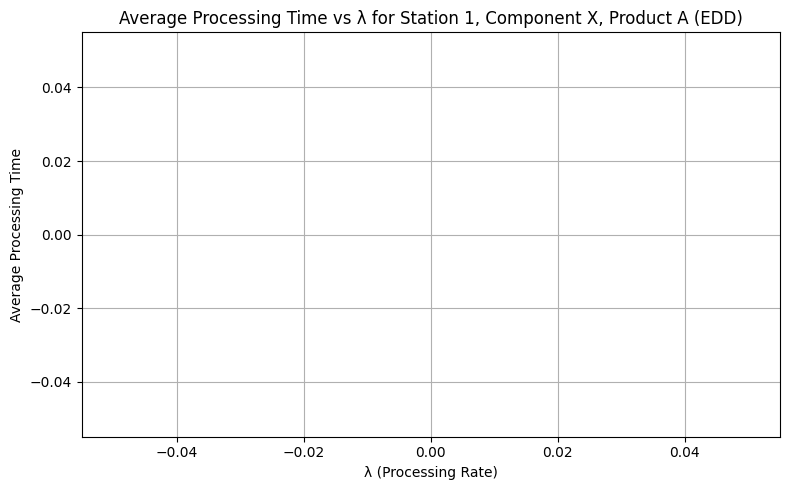

In [65]:
import os
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# הגדרות
folder_path = "."  # נתיב לתיקייה עם הקבצים
target_station = "1"
target_product = "A"
target_component = "x"
target_algorithm = "ALGORITHM_EDD"

# מילון לאחסון: λ → רשימת זמני עיבוד
lambda_proc_time = defaultdict(list)

# מעבר על קבצים בתיקייה
for filename in os.listdir(folder_path):
    if not filename.endswith(".pkl"):
        continue

    file_path = os.path.join(folder_path, filename)
    with open(file_path, "rb") as f:
        data = pickle.load(f)

    # סינון לפי אלגוריתם
    if data.get("ALGORITHM_KEY") != target_algorithm:
        continue

    # שליפת λ מתוך התפלגות זמן עיבוד
    lambda_val = data.get("PROCESSING_TIME_DISTRIBUTIONS", {}).get(target_component, {}).get(target_product)
    if lambda_val is None:
        continue

    # מעבר על זמני עיבוד לפי הזמנה
    for key, station_times in data.get("PROCESSING_TIME_PER_ORDER", {}).items():
        try:
            day, product, station = key.split("_")
            if product == target_product and station == target_station:
                proc_time = station_times.get(1)  # תחנה 1 כמספר
                if proc_time is not None:
                    lambda_proc_time[lambda_val].append(proc_time)
        except ValueError:
            continue  # אם המבנה שגוי

# חישוב ממוצעים
lambda_vals = sorted(lambda_proc_time.keys())
avg_proc_times = [np.mean(lambda_proc_time[lam]) for lam in lambda_vals]

# גרף
plt.figure(figsize=(8, 5))
plt.plot(lambda_vals, avg_proc_times, marker='o', linestyle='-', color='royalblue')
plt.title("Average Processing Time vs λ for Station 1, Component X, Product A (EDD)")
plt.xlabel("λ (Processing Rate)")
plt.ylabel("Average Processing Time")
plt.grid(True)
plt.tight_layout()
plt.show()


In [66]:
import pickle

# Load the pickle file
with open("simulation_results_2025_08_04_11_26_37.pkl", "rb") as f:
    data = pickle.load(f)

# Set to collect unique keys from each simulation day
all_keys = set()

# Check that key exists and is a list
if "SIMULATION_DAYS_ARRAY_KEY" in data and isinstance(data["SIMULATION_DAYS_ARRAY_KEY"], list):
    for day in data["SIMULATION_DAYS_ARRAY_KEY"]:
        if isinstance(day, dict):
            all_keys.update(day.keys())

# Print the sorted list of all keys
print("All keys found inside daily simulation entries:")
for key in sorted(all_keys):
    print("-", key)


All keys found inside daily simulation entries:
- CLOSEST_ORDER_KEY
- CUSTOMER_ORDERS_KEY
- DAY_KEY
- NEEDED_INGREDIENTS_KEY
- ORDER_FULFILLED_LIST
- SUPPLIER_ORDERS_KEY
- TOTAL_INCOME


In [67]:
import pickle

# Load the pickle file
with open("simulation_results_2025_08_04_11_26_37.pkl", "rb") as f:
    data = pickle.load(f)

# Extract one day from the simulation
simulation_days = data.get("SIMULATION_DAYS_ARRAY_KEY", [])

if simulation_days and isinstance(simulation_days[0], dict):
    first_day = simulation_days[0]
    
    print("=== Keys in Daily Simulation Entry ===")
    for key in sorted(first_day.keys()):
        print(f"\n🔑 {key}:")
        
        value = first_day[key]
        
        # Show only partial output if it's a large list or dict
        if isinstance(value, list):
            print(f"Type: list, Length: {len(value)}")
            if len(value) > 0:
                print("First item:", value[0])
        elif isinstance(value, dict):
            print(f"Type: dict, Keys: {list(value.keys())[:5]}")
        else:
            print("Value:", value)
else:
    print("No valid simulation day data found.")


=== Keys in Daily Simulation Entry ===

🔑 CLOSEST_ORDER_KEY:
Type: dict, Keys: ['order_id', 'products', 'due_time', 'status', 'created_at']

🔑 CUSTOMER_ORDERS_KEY:
Type: list, Length: 6
First item: {'customer_id': 0, 'max_lead_time': 2, 'order_cost': 16, 'orders': [{'order_id': '0_1_1', 'products': [({'product_id': 'A', 'volume_per_unit': 1.0, 'cost': 16}, 3), ({'product_id': 'B', 'volume_per_unit': 1.5, 'cost': 19}, 7)], 'due_time': 2, 'status': 'WAITING', 'created_at': 1}]}

🔑 DAY_KEY:
Value: 1

🔑 NEEDED_INGREDIENTS_KEY:
Type: dict, Keys: ['needed_ingredients', 'closest_lead_time', 'cheapest_supplier']

🔑 ORDER_FULFILLED_LIST:
Type: list, Length: 1
First item: 2_1_1

🔑 SUPPLIER_ORDERS_KEY:
Type: list, Length: 1
First item: {'supplier_id': 0, 'lead_time': 7, 'fixed_order_cost': 25, 'raw_material_cost_distribution': [({'product_id': 'x', 'volume_per_unit': 2.0, 'cost': 0.0}, 6), ({'product_id': 'y', 'volume_per_unit': 1.2, 'cost': 0.0}, 9), ({'product_id': 'z', 'volume_per_unit': 1.8, 

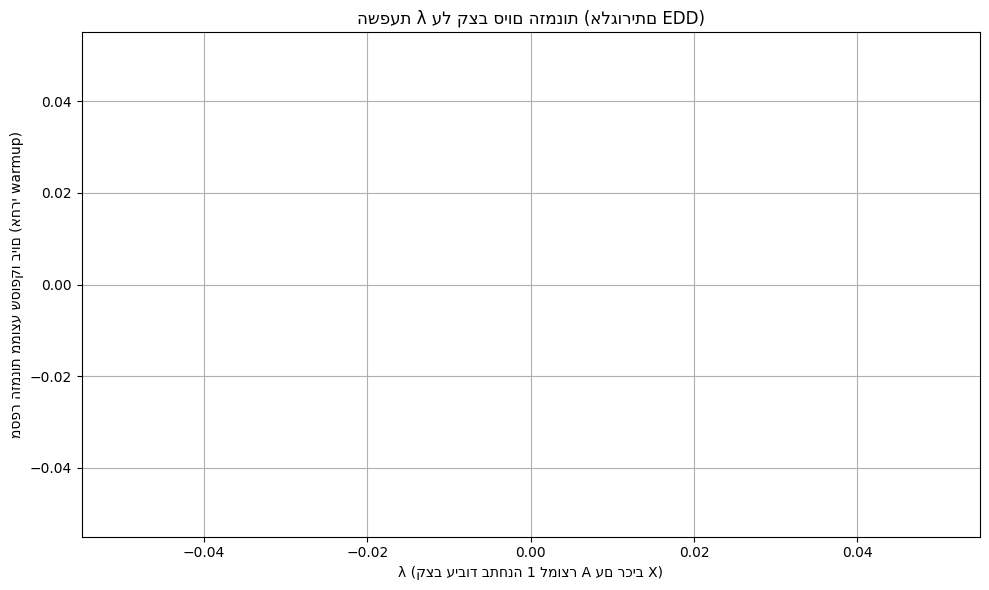

In [68]:
import os
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt

# === הגדרות ===
folder_path = "."  # התיקייה שבה נמצאים קבצי הסימולציה
warmup_days = 60
target_station = "1"        # תחנה 1
target_component = "1"      # רכיב X
target_product = "1"        # מוצר A
target_algorithm = "ALGORITHM_EDD"

# === משתנה לאיסוף נתונים: λ -> רשימת ממוצעים
lambda_to_fulfilled_per_day = defaultdict(list)

# === מעבר על כל הקבצים בתיקייה ===
for filename in os.listdir(folder_path):
    if not filename.endswith(".pkl"):
        continue

    file_path = os.path.join(folder_path, filename)
    with open(file_path, "rb") as file:
        data = pickle.load(file)

    # בדיקת אלגוריתם
    if data.get("ALGORITHM_KEY") != target_algorithm:
        continue

    # שליפת λ מתוך הקובץ (לפי התחנה, מוצר, ורכיב)
    try:
        lam = data["PROCESSING_TIME_DISTRIBUTIONS"][target_component][target_product]
    except KeyError:
        continue

    # רשומות יומיות מהסימולציה
    daily_entries = data.get("SIMULATION_DAYS_ARRAY_KEY", [])
    total_orders = 0
    valid_days = 0

    for entry in daily_entries:
        day = entry.get("DAY_KEY")
        if day is None or day < warmup_days:
            continue

        fulfilled = entry.get("ORDER_FULFILLED_LIST", [])
        
        # סינון לפי תחנה 1, מוצר A, רכיב X בלבד
        relevant_orders = [
            oid for oid in fulfilled
            if oid.startswith(f"{target_station}_{target_product}_{target_component}")
        ]
        total_orders += len(relevant_orders)
        valid_days += 1

    # חישוב ממוצע יומי
    if valid_days > 0:
        avg_per_day = total_orders / valid_days
        lambda_to_fulfilled_per_day[lam].append(avg_per_day)

# === עיבוד נתונים לגרף ===
lambda_vals = sorted(lambda_to_fulfilled_per_day.keys())
avg_orders_list = [sum(vals) / len(vals) for vals in [lambda_to_fulfilled_per_day[l] for l in lambda_vals]]

# === שרטוט ===
plt.figure(figsize=(10, 6))
plt.plot(lambda_vals, avg_orders_list, marker='o')
plt.xlabel("λ (קצב עיבוד בתחנה 1 למוצר A עם רכיב X)")
plt.ylabel("מספר הזמנות ממוצע שסופקו ביום (אחרי warmup)")
plt.title("השפעת λ על קצב סיום הזמנות (אלגוריתם EDD)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pickle

# Load the pickle file
with open("simulation_results_2025_08_04_11_26_37.pkl", "rb") as f:
    data = pickle.load(f)

# Extract one day from the simulation
simulation_days = data.get("SIMULATION_DAYS_ARRAY_KEY", [])

if simulation_days and isinstance(simulation_days[30], dict):
    first_day = simulation_days[0]
    
    print("=== Keys in Daily Simulation Entry ===")
    for key in sorted(first_day.keys()):
        print(f"\n🔑 {key}:")
        
        value = first_day[key]
        
        # Show only partial output if it's a large list or dict
        if isinstance(value, list):
            print(f"Type: list, Length: {len(value)}")
            if len(value) > 0:
                print("First item:", value[0])
        elif isinstance(value, dict):
            print(f"Type: dict, Keys: {list(value.keys())[:5]}")
        else:
            print("Value:", value)
else:
    print("No valid simulation day data found.")


=== Keys in Daily Simulation Entry ===

🔑 CLOSEST_ORDER_KEY:
Type: dict, Keys: ['order_id', 'products', 'due_time', 'status', 'created_at']

🔑 CUSTOMER_ORDERS_KEY:
Type: list, Length: 6
First item: {'customer_id': 0, 'max_lead_time': 2, 'order_cost': 16, 'orders': [{'order_id': '0_1_1', 'products': [({'product_id': 'A', 'volume_per_unit': 1.0, 'cost': 16}, 3), ({'product_id': 'B', 'volume_per_unit': 1.5, 'cost': 19}, 7)], 'due_time': 2, 'status': 'WAITING', 'created_at': 1}]}

🔑 DAY_KEY:
Value: 1

🔑 NEEDED_INGREDIENTS_KEY:
Type: dict, Keys: ['needed_ingredients', 'closest_lead_time', 'cheapest_supplier']

🔑 ORDER_FULFILLED_LIST:
Type: list, Length: 1
First item: 2_1_1

🔑 SUPPLIER_ORDERS_KEY:
Type: list, Length: 1
First item: {'supplier_id': 0, 'lead_time': 7, 'fixed_order_cost': 25, 'raw_material_cost_distribution': [({'product_id': 'x', 'volume_per_unit': 2.0, 'cost': 0.0}, 6), ({'product_id': 'y', 'volume_per_unit': 1.2, 'cost': 0.0}, 9), ({'product_id': 'z', 'volume_per_unit': 1.8, 

In [72]:
import os
import pickle

# === הגדרות ===
folder_path = "."  # תיקייה עם הקבצים
warmup_days = 60
target_product = "A"
target_algorithm = "ALGORITHM_EDD"

# === מעבר על הקבצים ===
for filename in os.listdir(folder_path):
    if not filename.endswith(".pkl"):
        continue

    file_path = os.path.join(folder_path, filename)
    with open(file_path, "rb") as file:
        data = pickle.load(file)

    # בדיקת אלגוריתם
    if data.get("ALGORITHM_KEY") != target_algorithm:
        continue

    # שליפת כל ההזמנות מכל הימים כדי לבנות מילון order_id → products
    order_to_products = {}
    for day_entry in data.get("SIMULATION_DAYS_ARRAY_KEY", []):
        for customer in day_entry.get("CUSTOMER_ORDERS_KEY", []):
            for order in customer.get("orders", []):
                order_id = order.get("order_id")
                product_list = order.get("products", [])
                product_ids = [p[0].get("product_id") for p in product_list if isinstance(p, tuple)]
                if order_id:
                    order_to_products[order_id] = product_ids

    # בדיקה אם יש הזמנה שסופקה עם מוצר A אחרי warmup
    found = False
    for day_entry in data.get("SIMULATION_DAYS_ARRAY_KEY", []):
        if day_entry.get("DAY_KEY", 0) < warmup_days:
            continue

        fulfilled_orders = day_entry.get("ORDER_FULFILLED_LIST", [])
        for order_id in fulfilled_orders:
            if target_product in order_to_products.get(order_id, []):
                print(f"✔ נמצא! בקובץ {filename} ביום {day_entry['DAY_KEY']} סופקה ההזמנה {order_id} הכוללת את מוצר A.")
                found = True
                break
        if found:
            break

    if not found:
        print(f"✘ בקובץ {filename} לא נמצאה אף הזמנה שסופקה עם מוצר A אחרי יום {warmup_days}.")


✔ נמצא! בקובץ simulation_results_2025_08_04_09_52_45.pkl ביום 63 סופקה ההזמנה 7_62_2 הכוללת את מוצר A.
✔ נמצא! בקובץ simulation_results_2025_08_04_09_54_03.pkl ביום 60 סופקה ההזמנה 2_60_23 הכוללת את מוצר A.


KeyboardInterrupt: 

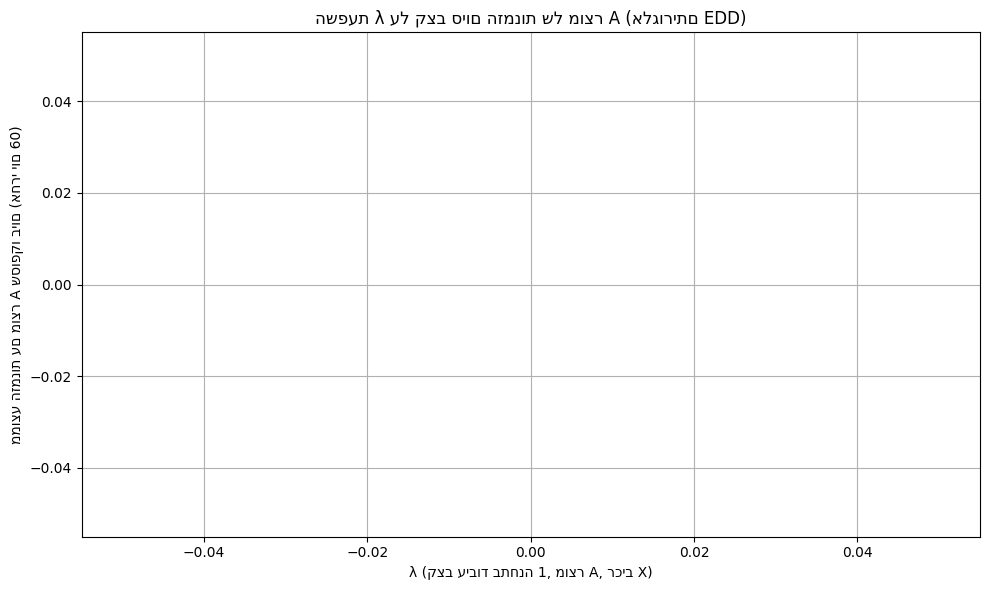

In [73]:
import os
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt

# === הגדרות ===
folder_path = "."  # התיקייה שבה הקבצים
warmup_days = 60
target_station = "1"        # תחנה 1
target_component = "1"      # רכיב X
target_product = "A"        # מוצר A
target_algorithm = "ALGORITHM_EDD"

# תוצאה: λ -> רשימת ממוצעים יומיים של הזמנות שסופקו עם מוצר A
lambda_to_avg_orders = defaultdict(list)

# === סריקה על כל הקבצים ===
for filename in os.listdir(folder_path):
    if not filename.endswith(".pkl"):
        continue

    file_path = os.path.join(folder_path, filename)
    with open(file_path, "rb") as file:
        data = pickle.load(file)

    # סינון לפי אלגוריתם
    if data.get("ALGORITHM_KEY") != target_algorithm:
        continue

    # שליפת λ עבור תחנה 1, מוצר A, רכיב X
    try:
        lam = data["PROCESSING_TIME_DISTRIBUTIONS"]["1"]["1"]
    except KeyError:
        continue

    # יצירת מילון order_id -> רשימת product_ids שהוזמנו (מכל הימים)
    order_to_products = {}
    for day_entry in data.get("SIMULATION_DAYS_ARRAY_KEY", []):
        for customer in day_entry.get("CUSTOMER_ORDERS_KEY", []):
            for order in customer.get("orders", []):
                order_id = order.get("order_id")
                product_list = order.get("products", [])
                product_ids = [p[0].get("product_id") for p in product_list if isinstance(p, tuple)]
                if order_id:
                    order_to_products[order_id] = product_ids

    # חישוב מספר הזמנות שסופקו עם מוצר A בכל יום
    daily_counts = []
    for day_entry in data.get("SIMULATION_DAYS_ARRAY_KEY", []):
        day = day_entry.get("DAY_KEY", 0)
        if day < warmup_days:
            continue

        fulfilled_orders = day_entry.get("ORDER_FULFILLED_LIST", [])
        count_A = 0
        for order_id in fulfilled_orders:
            products = order_to_products.get(order_id, [])
            if target_product in products:
                count_A += 1

        daily_counts.append(count_A)

    # ממוצע יומי
    if daily_counts:
        avg = sum(daily_counts) / len(daily_counts)
        lambda_to_avg_orders[lam].append(avg)

# === גרף ===
lambda_vals = sorted(lambda_to_avg_orders.keys())
avg_fulfilled_per_day = [sum(v) / len(v) for v in [lambda_to_avg_orders[l] for l in lambda_vals]]

plt.figure(figsize=(10, 6))
plt.plot(lambda_vals, avg_fulfilled_per_day, marker='o')
plt.xlabel("λ (קצב עיבוד בתחנה 1, מוצר A, רכיב X)")
plt.ylabel("ממוצע הזמנות עם מוצר A שסופקו ביום (אחרי יום 60)")
plt.title("השפעת λ על קצב סיום הזמנות של מוצר A (אלגוריתם EDD)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [74]:
import os
import pickle

folder_path = "."
warmup_days = 60
target_product = "A"
target_algorithm = "ALGORITHM_EDD"

for filename in os.listdir(folder_path):
    if not filename.endswith(".pkl"):
        continue

    with open(os.path.join(folder_path, filename), "rb") as file:
        data = pickle.load(file)

    if data.get("ALGORITHM_KEY") != target_algorithm:
        continue

    # נסה לשלוף λ
    try:
        lam = data["PROCESSING_TIME_DISTRIBUTIONS"]["1"]["1"]
    except KeyError:
        print(f"⚠️ בקובץ {filename} אין λ בתחנה 1 למוצר A.")
        continue

    # בניית מיפוי order_id → products
    order_to_products = {}
    for day_entry in data.get("SIMULATION_DAYS_ARRAY_KEY", []):
        for customer in day_entry.get("CUSTOMER_ORDERS_KEY", []):
            for order in customer.get("orders", []):
                order_id = order.get("order_id")
                product_list = order.get("products", [])
                product_ids = [p[0].get("product_id") for p in product_list if isinstance(p, tuple)]
                if order_id:
                    order_to_products[order_id] = product_ids

    # חישוב ממוצע יומי
    daily_counts = []
    for day_entry in data.get("SIMULATION_DAYS_ARRAY_KEY", []):
        day = day_entry.get("DAY_KEY", 0)
        if day < warmup_days:
            continue

        fulfilled_orders = day_entry.get("ORDER_FULFILLED_LIST", [])
        count_A = 0
        for order_id in fulfilled_orders:
            if target_product in order_to_products.get(order_id, []):
                count_A += 1

        daily_counts.append(count_A)

    if daily_counts:
        avg = sum(daily_counts) / len(daily_counts)
        print(f"✔ λ={lam} בקובץ {filename}: ממוצע הזמנות A שסופקו ביום אחרי warmup: {avg:.2f}")
    else:
        print(f"❌ בקובץ {filename} אין בכלל ימים עם הזמנות A שסופקו אחרי יום {warmup_days}.")


⚠️ בקובץ simulation_results_2025_08_04_09_52_45.pkl אין λ בתחנה 1 למוצר A.
⚠️ בקובץ simulation_results_2025_08_04_09_54_03.pkl אין λ בתחנה 1 למוצר A.
⚠️ בקובץ simulation_results_2025_08_04_09_57_20.pkl אין λ בתחנה 1 למוצר A.


KeyboardInterrupt: 

In [75]:
import os
import pickle

folder_path = "."  # או הנתיב לתיקייה שלך
target_component = "x"  # רכיב X
target_product = "A"    # מוצר A

for filename in os.listdir(folder_path):
    if not filename.endswith(".pkl"):
        continue

    file_path = os.path.join(folder_path, filename)
    with open(file_path, "rb") as file:
        data = pickle.load(file)

    lambda_dict = data.get("PROCESSING_TIME_DISTRIBUTIONS", {})
    lam = lambda_dict.get(target_component, {}).get(target_product)

    if lam is not None:
        print(f"✔ בקובץ {filename} נמצא λ={lam} עבור רכיב {target_component} ומוצר {target_product}")
    else:
        print(f"✘ בקובץ {filename} לא נמצא λ עבור רכיב {target_component} ומוצר {target_product}")


✔ בקובץ simulation_results_2025_08_04_09_52_45.pkl נמצא λ=0.2 עבור רכיב x ומוצר A
✔ בקובץ simulation_results_2025_08_04_09_52_52.pkl נמצא λ=0.2 עבור רכיב x ומוצר A
✔ בקובץ simulation_results_2025_08_04_09_53_04.pkl נמצא λ=0.2 עבור רכיב x ומוצר A
✔ בקובץ simulation_results_2025_08_04_09_53_19.pkl נמצא λ=0.2 עבור רכיב x ומוצר A
✔ בקובץ simulation_results_2025_08_04_09_53_34.pkl נמצא λ=0.2 עבור רכיב x ומוצר A
✔ בקובץ simulation_results_2025_08_04_09_54_03.pkl נמצא λ=0.2 עבור רכיב x ומוצר A
✔ בקובץ simulation_results_2025_08_04_09_54_15.pkl נמצא λ=0.2 עבור רכיב x ומוצר A
✔ בקובץ simulation_results_2025_08_04_09_54_31.pkl נמצא λ=0.2 עבור רכיב x ומוצר A
✔ בקובץ simulation_results_2025_08_04_09_55_04.pkl נמצא λ=0.2 עבור רכיב x ומוצר A


KeyboardInterrupt: 

[OK] simulation_results_2025_08_04_09_52_45.pkl → λ=0.2 → daily avg A-fulfillment: 0.58
[SKIP] simulation_results_2025_08_04_09_52_52.pkl is not using ALGORITHM_EDD
[SKIP] simulation_results_2025_08_04_09_53_04.pkl is not using ALGORITHM_EDD
[SKIP] simulation_results_2025_08_04_09_53_19.pkl is not using ALGORITHM_EDD
[SKIP] simulation_results_2025_08_04_09_53_34.pkl is not using ALGORITHM_EDD
[OK] simulation_results_2025_08_04_09_54_03.pkl → λ=0.2 → daily avg A-fulfillment: 0.72
[SKIP] simulation_results_2025_08_04_09_54_15.pkl is not using ALGORITHM_EDD
[SKIP] simulation_results_2025_08_04_09_54_31.pkl is not using ALGORITHM_EDD
[SKIP] simulation_results_2025_08_04_09_55_04.pkl is not using ALGORITHM_EDD
[SKIP] simulation_results_2025_08_04_09_57_07.pkl is not using ALGORITHM_EDD
[OK] simulation_results_2025_08_04_09_57_20.pkl → λ=0.2 → daily avg A-fulfillment: 0.58
[SKIP] simulation_results_2025_08_04_09_57_34.pkl is not using ALGORITHM_EDD
[SKIP] simulation_results_2025_08_04_09_57_

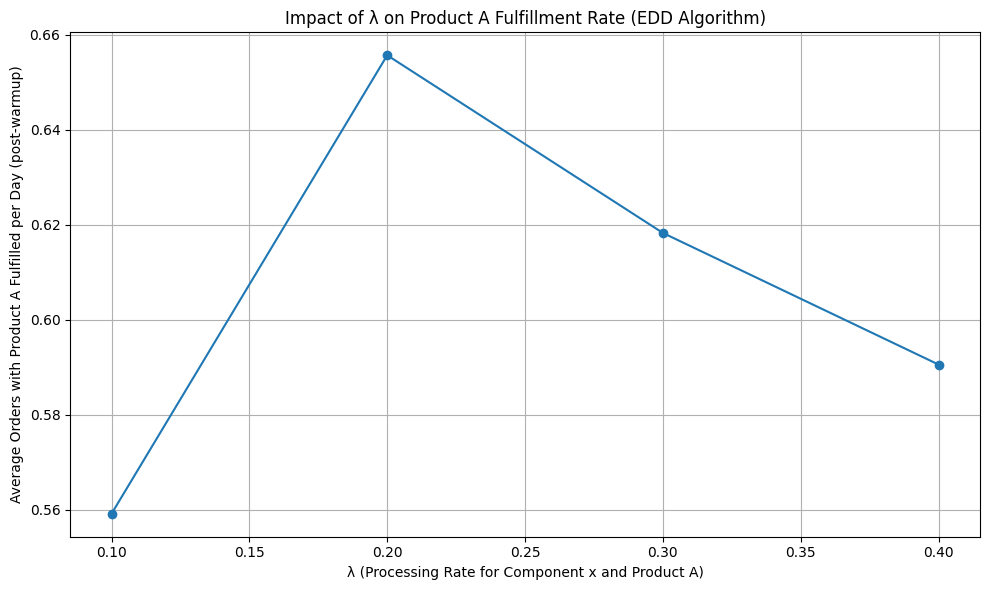

In [ ]:
folder_path = "."  # Folder with simulation .pkl files
warmup_days = 60
target_component = "x"  # Component X
target_product = "A"    # Product A
target_algorithm = "ALGORITHM_EDD"

# Output container: lambda → list of average orders fulfilled per day
lambda_to_avg_orders = defaultdict(list)

# Scan all files
for filename in os.listdir(folder_path):
    if not filename.endswith(".pkl"):
        continue

    file_path = os.path.join(folder_path, filename)
    with open(file_path, "rb") as file:
        data = pickle.load(file)

    # Skip files not using the required algorithm
    if data.get("ALGORITHM_KEY") != target_algorithm:
        print(f"[SKIP] {filename} is not using {target_algorithm}")
        continue

    # Extract lambda value for component x, product A
    lambda_dict = data.get("PROCESSING_TIME_DISTRIBUTIONS", {})
    lam = lambda_dict.get(target_component, {}).get(target_product)

    if lam is None:
        print(f"[WARN] Lambda not found for component {target_component}, product {target_product} in {filename}")
        continue

    # Build order_id → product_ids map from all days
    order_to_products = {}
    for day_entry in data.get("SIMULATION_DAYS_ARRAY_KEY", []):
        for customer in day_entry.get("CUSTOMER_ORDERS_KEY", []):
            for order in customer.get("orders", []):
                order_id = order.get("order_id")
                product_list = order.get("products", [])
                product_ids = [p[0].get("product_id") for p in product_list if isinstance(p, tuple)]
                if order_id:
                    order_to_products[order_id] = product_ids

    # Count how many fulfilled orders per day include product A
    daily_counts = []
    for day_entry in data.get("SIMULATION_DAYS_ARRAY_KEY", []):
        day = day_entry.get("DAY_KEY", 0)
        if day < warmup_days:
            continue

        fulfilled_orders = day_entry.get("ORDER_FULFILLED_LIST", [])
        count_A = 0
        for order_id in fulfilled_orders:
            if target_product in order_to_products.get(order_id, []):
                count_A += 1

        daily_counts.append(count_A)

    if daily_counts:
        avg = sum(daily_counts) / len(daily_counts)
        lambda_to_avg_orders[lam].append(avg)
        print(f"[OK] {filename} → λ={lam} → daily avg A-fulfillment: {avg:.2f}")
    else:
        print(f"[NO A-FULFILL] {filename} → λ={lam} → no A orders fulfilled after day {warmup_days}")

# Prepare data for plot
lambda_vals = sorted(lambda_to_avg_orders.keys())
avg_fulfilled_per_day = [sum(v) / len(v) for v in [lambda_to_avg_orders[l] for l in lambda_vals]]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(lambda_vals, avg_fulfilled_per_day, marker='o')
plt.xlabel("λ (Processing Rate for Component x and Product A)")
plt.ylabel("Average Orders with Product A Fulfilled per Day (post-warmup)")
plt.title("Impact of λ on Product A Fulfillment Rate (EDD Algorithm)")
plt.grid(True)
plt.tight_layout()
plt.show()